<a href="https://colab.research.google.com/github/JohnRoeder5/Driver-Attention/blob/main/stat_arbitrage_Jroeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

starting tickers: VMI, RS, FLS, DHR

steps:
1. find the correlation between stocks. need to be in similar markets and need to be cointegrated
2. determine stationarity
3. determine threshold (z-score)
4. consider using moving averages and mean reversion.


In [ ]:
#imports
import threading
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sea
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

from sklearn import svm
from datetime import datetime, timedelta
import math
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics



REMEMBER THAT .tail() gets the most recent closing prices and .head() gets the oldest.


In [ ]:
#list of tickers. Get tickrs from yfinance


#tickers = ['CCI', 'AMT', 'SBAC']
tickers = ['WFC', 'BAC', 'JPM', 'MS', 'GS', 'C', 'USB']
#tickers = ['DUK', 'NEE', 'AEP']
#tickers = ['VMI', 'RS', 'FLS', 'DHR', 'CCI', 'AMT', 'SBAC', 'DUK', 'NEE', 'AEP', 'WFC', 'BAC', 'JPM', 'MS', 'GS', 'C', 'USB']
#tickers = ['ETH-USD', 'BTC-USD']
#tickers = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'BBVA', 'SAN', 'ING', 'UBS', 'HSBC', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB', 'BLK', 'MTB', 'ZION', 'FFIN', 'FHN', 'UBSI','SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'FULT', 'ONB', 'INDB', 'IBOC']
print(len(tickers))
def clean_dataset(dataset):
    # Interpolate missing values using linear interpolation
    dataset.interpolate(method='linear', axis=0, inplace=True)
    dataset.ffill(inplace=True)
    dataset.bfill(inplace=True)

    # Check if there are still NaN, None, or Inf values after interpolation
    if dataset.isnull().values.any() or (dataset == np.inf).any().any() or (dataset == -np.inf).any().any():
        return None  # If there are, return None

    # Replace inf and -inf with finite numbers (you can adjust this based on your needs)
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Replace NaN after handling inf
    dataset.fillna(0, inplace=True)

    # Replace None with a specific value, e.g., 0
    dataset.replace([None], 0, inplace=True)

    return dataset

dfs_dict = {}

# Create individual dfs
for ticker in tickers:
    get_data = yf.download(ticker, start='2013-01-01')
    cleaned_data = clean_dataset(get_data)

    if cleaned_data is not None:
        dfs_dict[ticker] = cleaned_data

print(len(dfs_dict))




7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

7


get the df of the closing prices for the stocks. plot the correlation coefficient heat map


(2838, 7)
['WFC_Close', 'BAC_Close', 'JPM_Close', 'MS_Close', 'GS_Close', 'C_Close', 'USB_Close']


Text(0.5, 1.0, 'Assets Correlation Matrix')

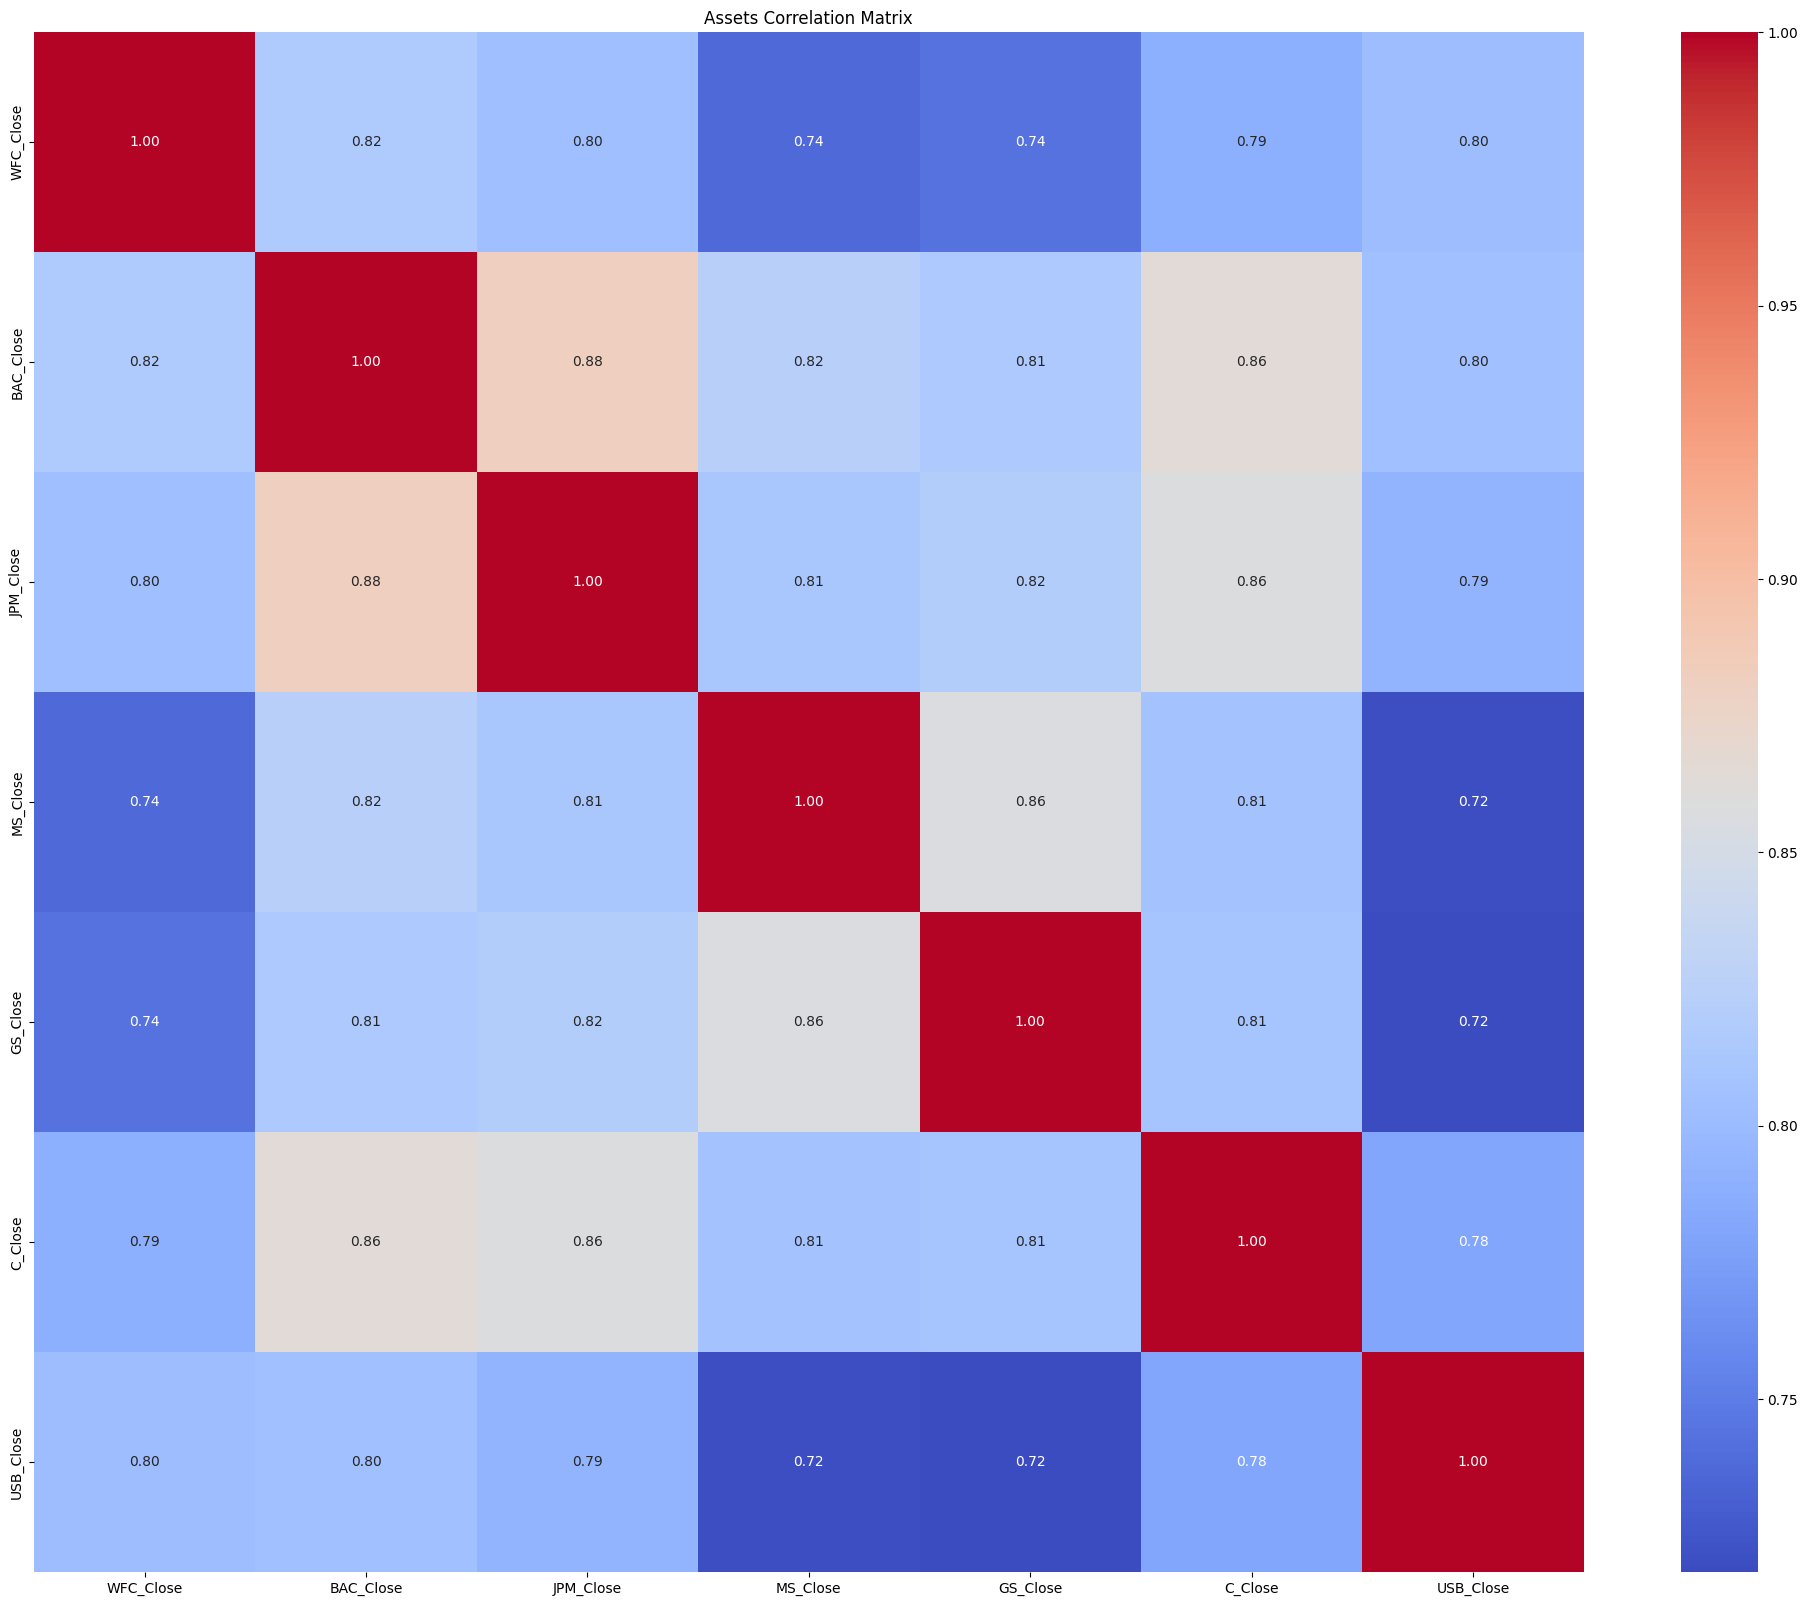

In [ ]:
#WHEN U GET NEW STOCKS NEED OT REPLACE THE TICKERS IN THE DICTIONARY

#all_stocks_close = pd.concat([dfs_dict['VMI']['Close'], dfs_dict['RS']['Close'], dfs_dict['FLS']['Close'], dfs_dict['DHR']['Close']], axis=1)
#all_stocks_close = pd.concat([dfs_dict['CCI']['Close'], dfs_dict['AMT']['Close'], dfs_dict['SBAC']['Close']], axis=1)
#all_stocks_close = pd.concat([dfs_dict['DUK']['Close'], dfs_dict['NEE']['Close'], dfs_dict['AEP']['Close']], axis=1)
#all_stocks_close = pd.concat([dfs_dict['WFC']['Close'], dfs_dict['BAC']['Close'], dfs_dict['JPM']['Close']], axis=1)
# all_stocks_close = pd.concat([dfs_dict['ETH-USD']['Close'], dfs_dict['BTC-USD']['Close']], axis=1)

all_stocks_close = pd.concat([dfs_dict[ticker]['Close'] for ticker in tickers], axis=1, keys=tickers)
print(all_stocks_close.shape)
#check if the column is NaN fir last price then replace with yesterdays close if it is
# print(all_stocks_close.tail())
for column in all_stocks_close.columns:
  last_price = all_stocks_close[column].iloc[-1]
  second_to_last_price= all_stocks_close[column].iloc[-2]
  if(np.isnan(last_price)):
    all_stocks_close[column].iloc[-1] = second_to_last_price

# print(all_stocks_close.head())

new_column_names = [f'{ticker}_Close' for ticker in tickers]
print(new_column_names)
# Rename the columns
all_stocks_close.columns = new_column_names


#check correlations using ehatmap:
fig, ax = plt.subplots(figsize=(25, 20))
sea.heatmap(all_stocks_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Assets Correlation Matrix')



7
Index(['WFC_Close', 'BAC_Close', 'JPM_Close', 'MS_Close', 'GS_Close',
       'C_Close', 'USB_Close'],
      dtype='object')
('MS_Close', 'GS_Close')
('C_Close', 'USB_Close')


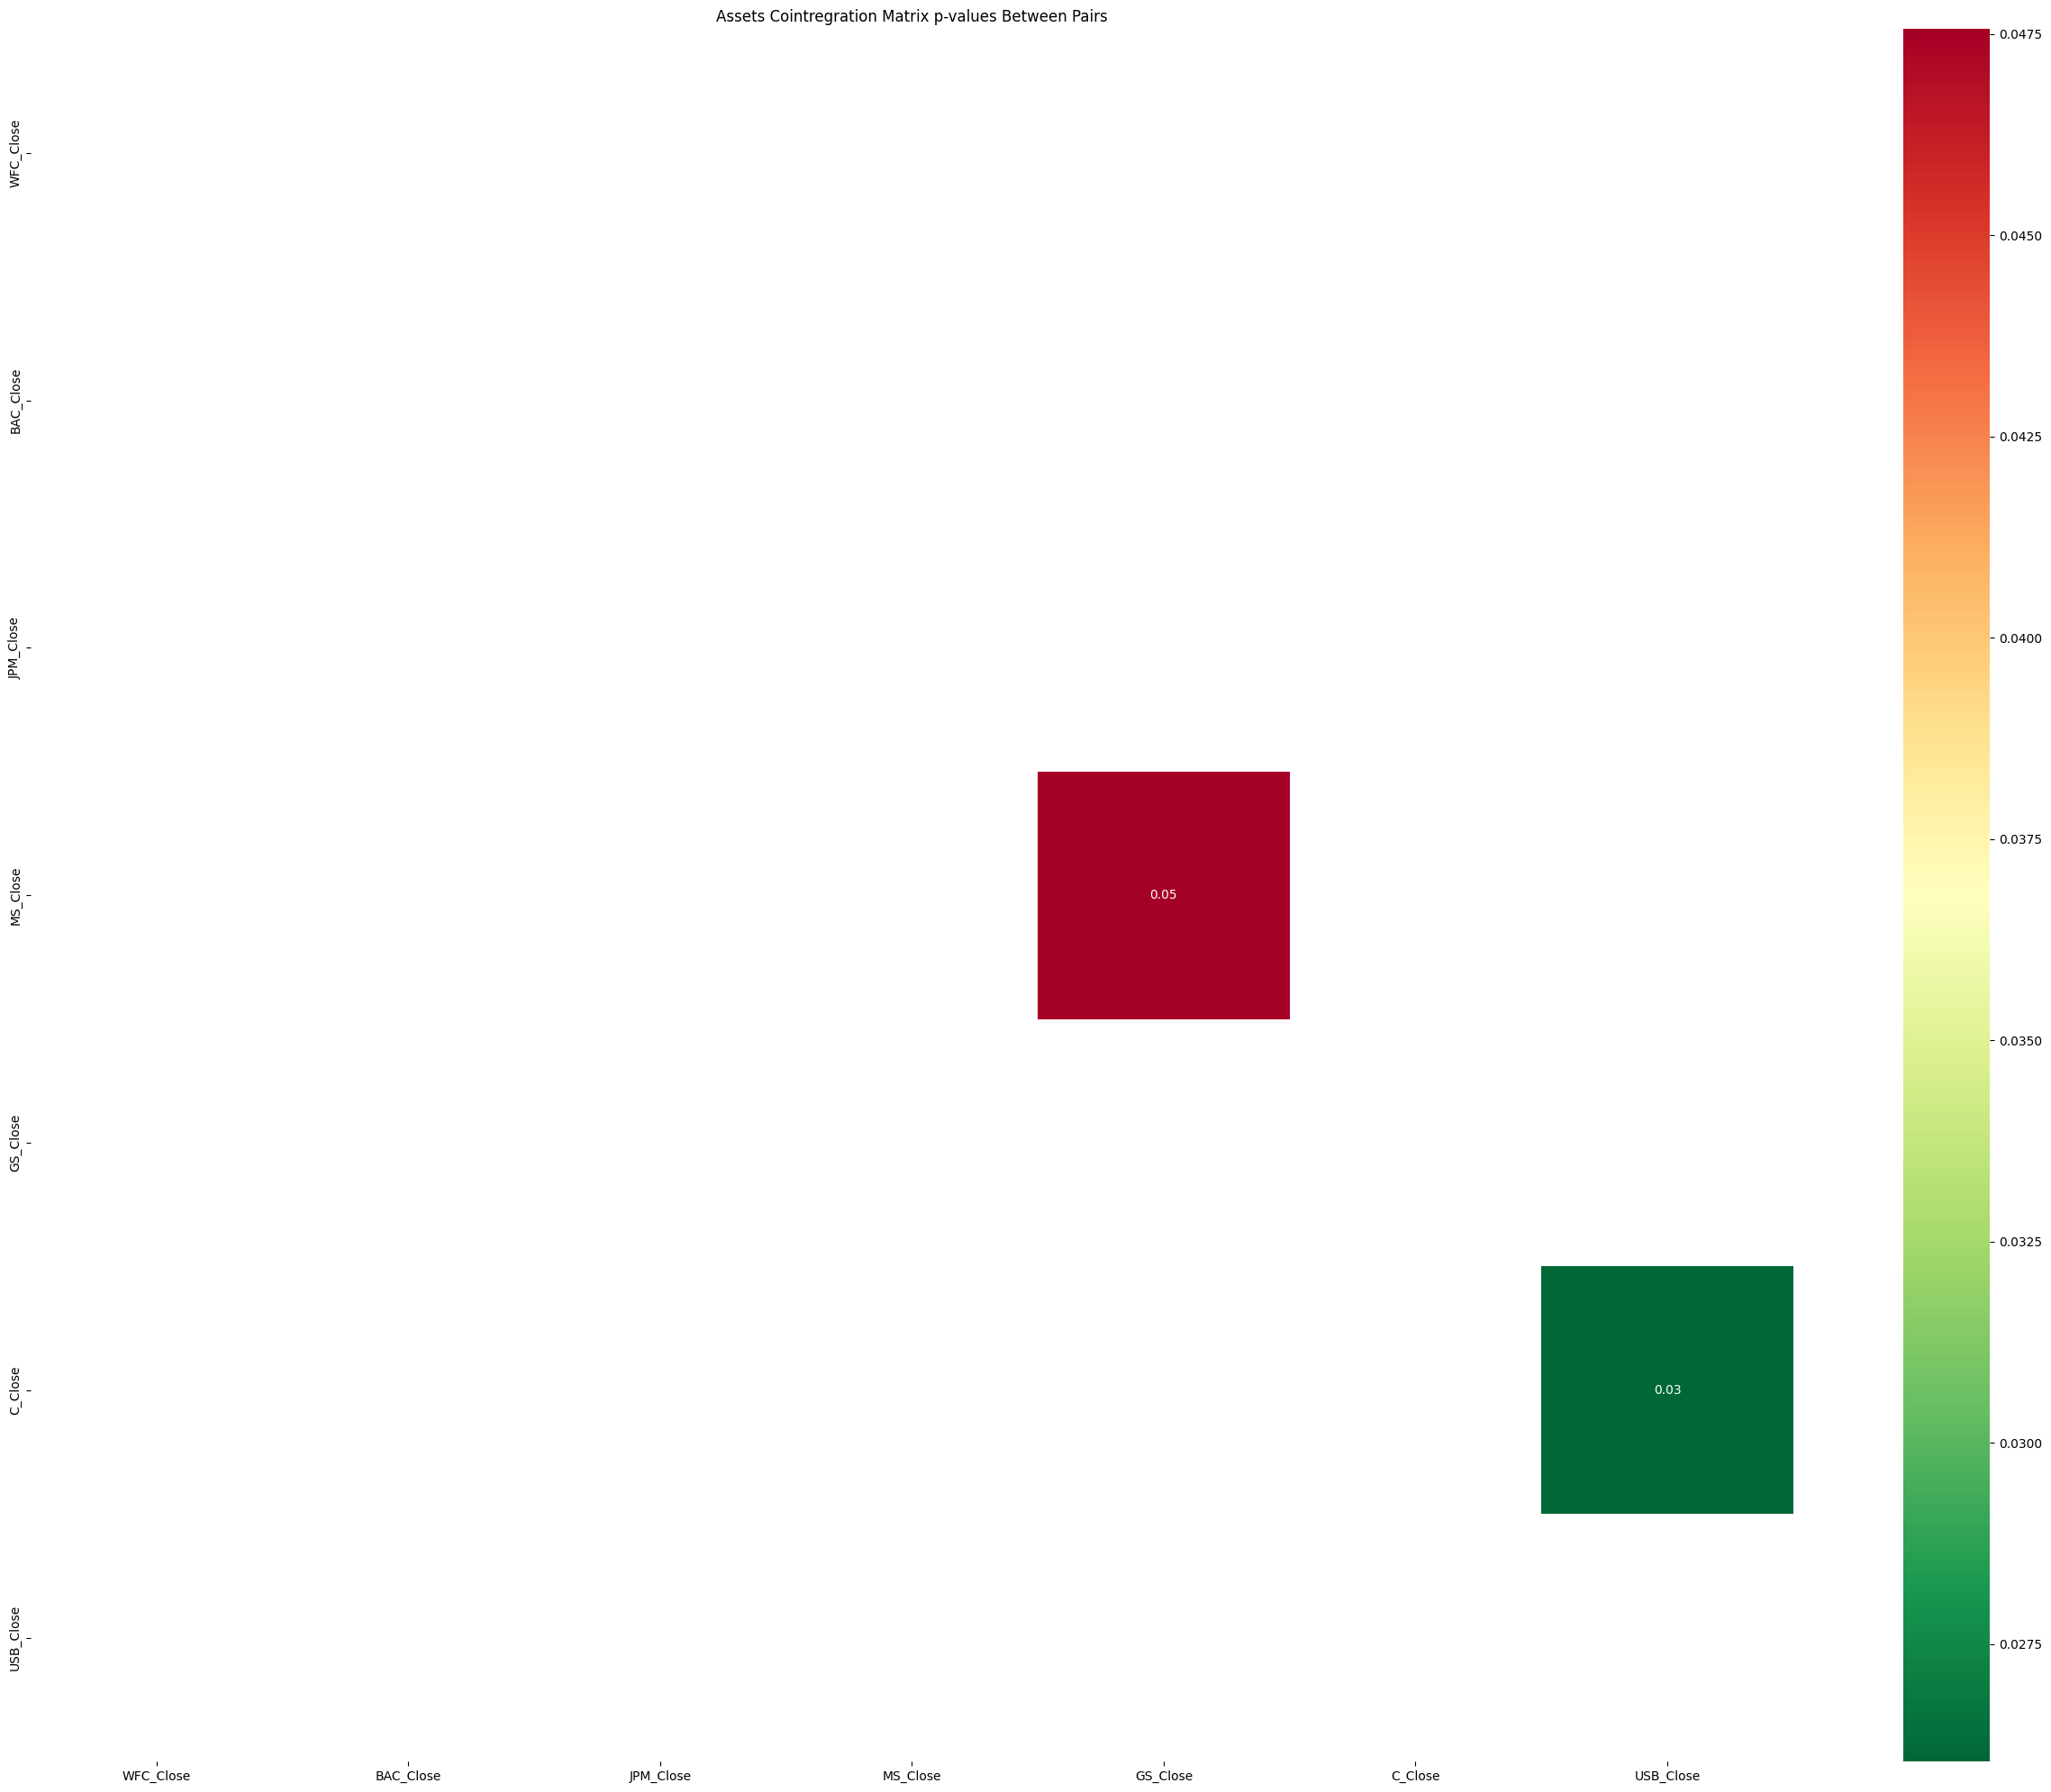

In [ ]:
#finding cointegrated pairs:
def get_coint_pairs(data):
    n = data.shape[1]
    print(n)
    p_matrix = np.ones((n, n))
    keys = data.keys()
    print(keys)
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
          try:
            result = coint(data[keys[i]], data[keys[j]])
            p_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
          except Exception as e:
            print(f"Error in key pair: {keys[i]}, {keys[j]}")
            print(e)
            return None






            # result = coint(data[keys[i]], data[keys[j]])
            # p_matrix[i, j] = result[1]
            # if result[1] < 0.05:
            #   pairs.append((keys[i], keys[j]))
    return p_matrix, pairs
# calculate p-values and plot as a heatmap
pvalues, pairs = get_coint_pairs(all_stocks_close)

for pair in pairs:
  print(pair)
fig, ax = plt.subplots(figsize=(25, 20))
sea.heatmap(pvalues, xticklabels = all_stocks_close.columns,
                yticklabels = all_stocks_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.05))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()

('MS_Close', 'GS_Close')
Hedge Ratio = 4.272196931011055
ADF Test for MS_Close and GS_Close:
Critical Value = -2.26943611947275
(-2.26943611947275, 0.18201494681021235, 0, 2837, {'1%': -3.432657094354157, '5%': -2.862559315261322, '10%': -2.5673126119599647}, 13376.810029238892)
-3.432657094354157


<ipython-input-9-99a70290442c>:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(2, 1, 2)


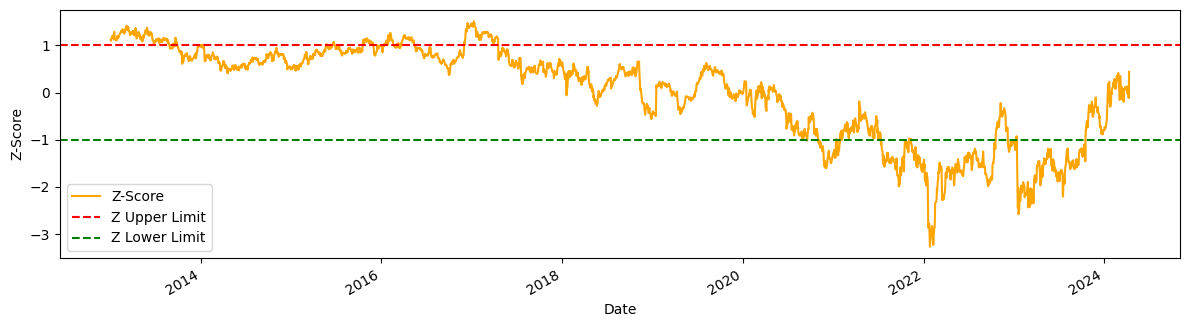





('C_Close', 'USB_Close')
Hedge Ratio = 0.8061149552396022


<ipython-input-9-99a70290442c>:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(2, 1, 2)


ADF Test for C_Close and USB_Close:
Critical Value = -3.1295559605767087
(-3.1295559605767087, 0.02444183754004872, 0, 2837, {'1%': -3.432657094354157, '5%': -2.862559315261322, '10%': -2.5673126119599647}, 4651.006992956369)
-3.432657094354157


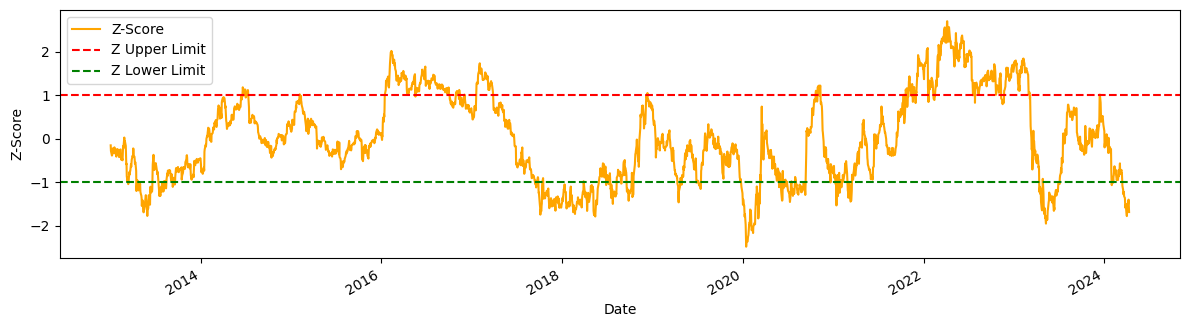





1


In [ ]:
#test for futhr stationaruyt using the Augemnted dcikey fuller

best_value = []
for pair in pairs:
  asset1, asset2 = pair
  print(pair)
  train = pd.DataFrame()
  train['asset1'] = all_stocks_close[asset1]
  train['asset2'] = all_stocks_close[asset2]
  #visualize the prces
  # ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
  # ax.set_ylabel("Closing Price")
  # ax.grid(True);

  # OLS regresion
  model=sm.OLS(train.asset2, train.asset1).fit()


  # print(f'Regression Summary for {asset1} and {asset2}:\n{model.summary()}')



  print(f'Hedge Ratio = {model.params[0]}')
  # results
  # plt.rc('figure', figsize=(12, 7))
  # plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
  # plt.axis('off')
  # plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)



  spread = train.asset2 - model.params[0] * train.asset1

  z_score = (spread - spread.mean()) / np.std(spread)


  z_upper_limit = np.mean(z_score) + np.std(z_score)
  z_lower_limit = np.mean(z_score) - np.std(z_score)


  plt.figure(figsize=(12, 6))
  ax = spread.plot(title="Pair's Spread")
  ax.set_ylabel("Spread")
  ax.grid(True)
  ax.legend(labels=[asset1+ ' '+asset2+ " Spread"])

  ax2 = plt.subplot(2, 1, 2)
  z_score.plot(ax=ax2, color='orange', label='Z-Score')
  ax2.axhline(y=z_upper_limit, color='red', linestyle='--', label='Z Upper Limit')
  ax2.axhline(y=z_lower_limit, color='green', linestyle='--', label='Z Lower Limit')
  ax2.set_ylabel("Z-Score")
  ax2.set_xlabel("Date")
  ax2.legend()



  # ADF test
  adf = adfuller(spread, maxlag = 1)
  print(f'ADF Test for {asset1} and {asset2}:')
  print(f'Critical Value = {adf[0]}')
  # criticl values
  print(adf)


  adf_dict = adf[4]

  print(adf_dict['1%'])
  plt.tight_layout()
  plt.show()
  print('\n')
  print('\n')
  #if critical val less than the smallest confidenece intervla add to list to use for strat.
  if(adf[0] < adf_dict['5%']):
    best_value.append(pair)

print(len(best_value))

In [ ]:
def calculate_sharpe_ratio(returns, risk_free_rate):
    mean_return = returns.mean()
    risk = returns.std()
    sharpe_ratio = (mean_return - risk_free_rate) / risk
    return sharpe_ratio

def plot_strategy(signals):
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(signals['asset1'])
    positions2 = initial_capital// max(signals['asset2'])

    # since there are two assets, we calculate each asset Pnl
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio['asset1'] = signals['asset1']
    portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
    portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = signals['positions1']
    # pnl for the 2nd asset
    portfolio['asset2'] = signals['asset2']
    portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
    portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = signals['positions2']

    # total pnl and z-score
    portfolio['z'] = signals['z']
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = signals['z upper limit']
    portfolio['z lower limit'] = signals['z lower limit']
    portfolio = portfolio.dropna()

    risk_free_rate = 0.02

    portfolio['total_return'] = portfolio['total asset'].pct_change()
    sharpe_ratio_total = calculate_sharpe_ratio(portfolio['total_return'], risk_free_rate)

#sharpe ratio calc
    print("Sharpe Ratio for Total Portfolio:", sharpe_ratio_total)

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics','Z Statistics +-1 Sigma','Total Portfolio Value'],loc='upper left');


    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    delta = (portfolio.index[-1] - portfolio.index[0]).days
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
    print('CAGR = {:.3f}%' .format(returns * 100))
    print(portfolio.tail())

BAC_Close
PNC_Close
Sharpe Ratio for Total Portfolio: -14.837137150936202


<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


Number of days =  4092
CAGR = 8.617%
               asset1     holdings1          cash1   total asset1   return1  \
Date                                                                          
2024-03-13  36.080002 -73062.003708  214007.504249  140945.500541 -0.001721   
2024-03-14  35.689999 -72272.247219  214007.504249  141735.257030  0.005603   
2024-03-15  35.410000 -71705.249691  214007.504249  142302.254558  0.004000   
2024-03-18  36.009998 -72920.246601  214007.504249  141087.257648 -0.008538   
2024-03-19  36.049999 -73001.248455  214007.504249  141006.255794 -0.000574   

            positions1      asset2     holdings2        cash2   total asset2  \
Date                                                                           
2024-03-13         0.0  152.720001  67349.520538  45461.51062  112811.031158   
2024-03-14         0.0  148.490005  65484.092422  45461.51062  110945.603043   
2024-03-15         0.0  148.779999  65611.979462  45461.51062  111073.490082   
2024-03-1

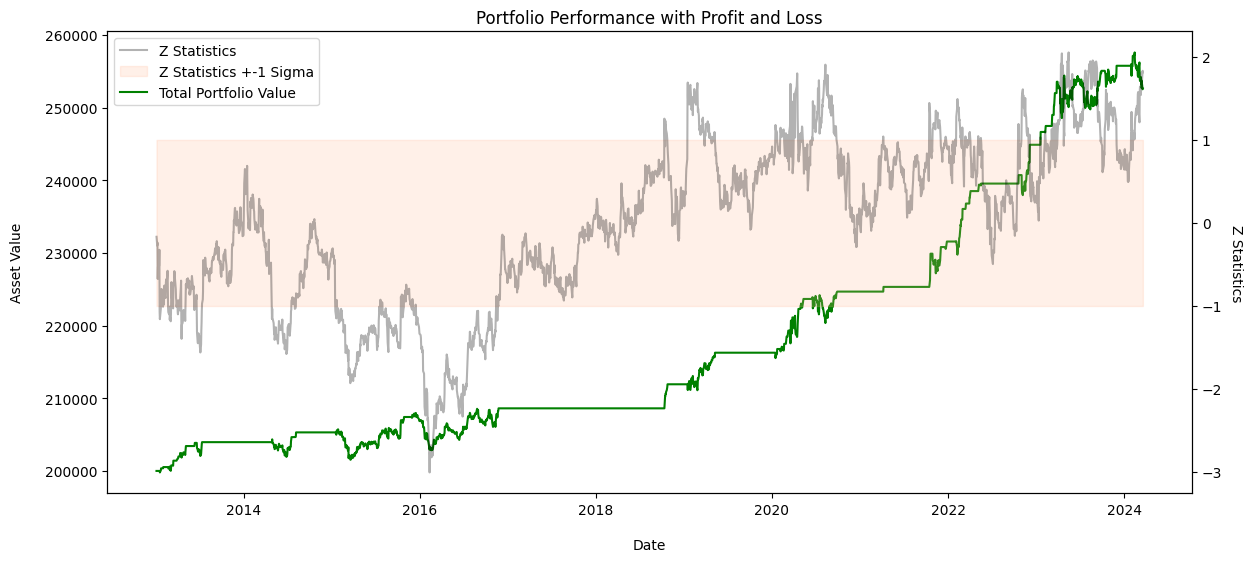

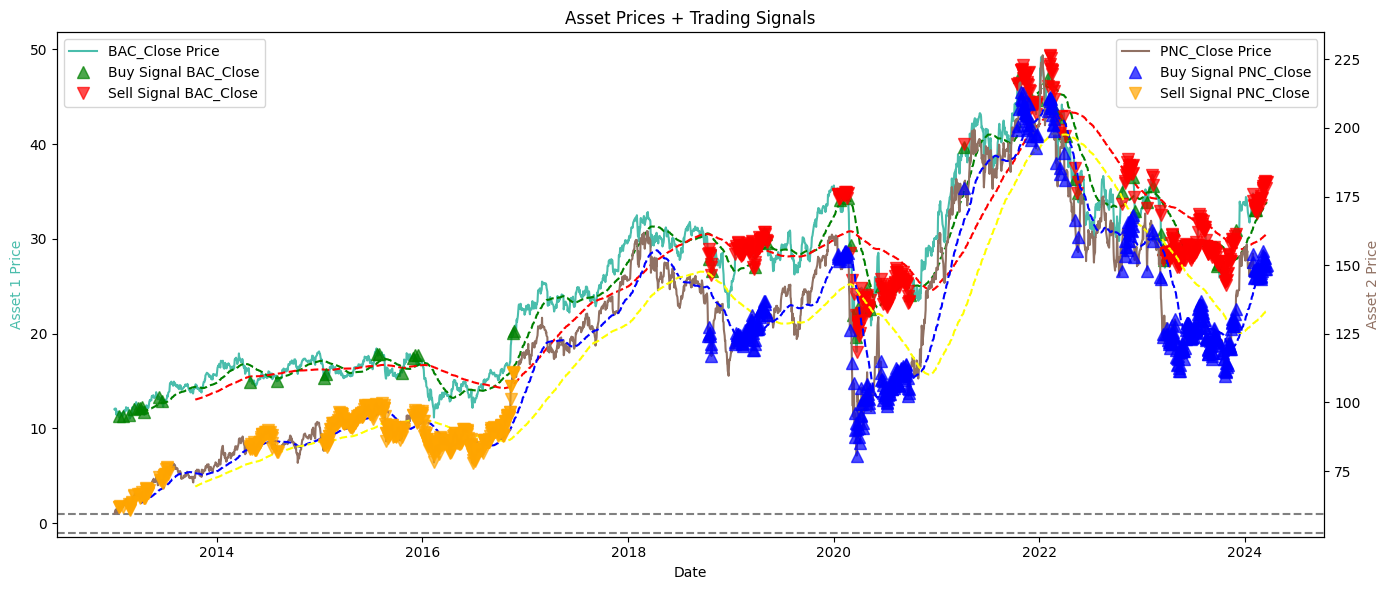

C_Close
USB_Close
Sharpe Ratio for Total Portfolio: -9.261982213292319
Number of days =  4092
CAGR = 10.031%
               asset1     holdings1          cash1   total asset1   return1  \
Date                                                                          
2024-03-13  57.759998      0.000000  211288.373566  211288.373566  0.000000   
2024-03-14  57.090000      0.000000  211288.373566  211288.373566  0.000000   
2024-03-15  57.610001 -70284.200745  281572.574310  211288.373566  0.000000   
2024-03-18  58.630001 -71528.601303  281572.574310  210043.973007 -0.005890   
2024-03-19  58.849998 -71796.998138  281572.574310  209775.576172 -0.001278   

            positions1     asset2     holdings2         cash2  total asset2  \
Date                                                                          
2024-03-13         0.0  43.470001      0.000000  82024.070890  82024.070890   
2024-03-14         0.0  42.349998      0.000000  82024.070890  82024.070890   
2024-03-15        -1.

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


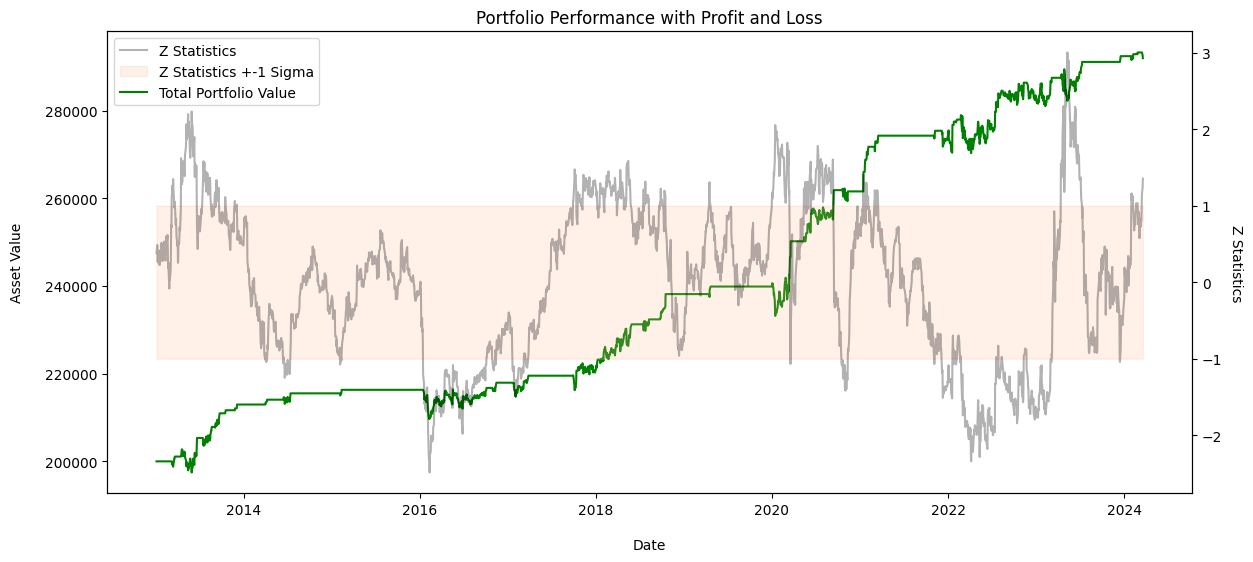

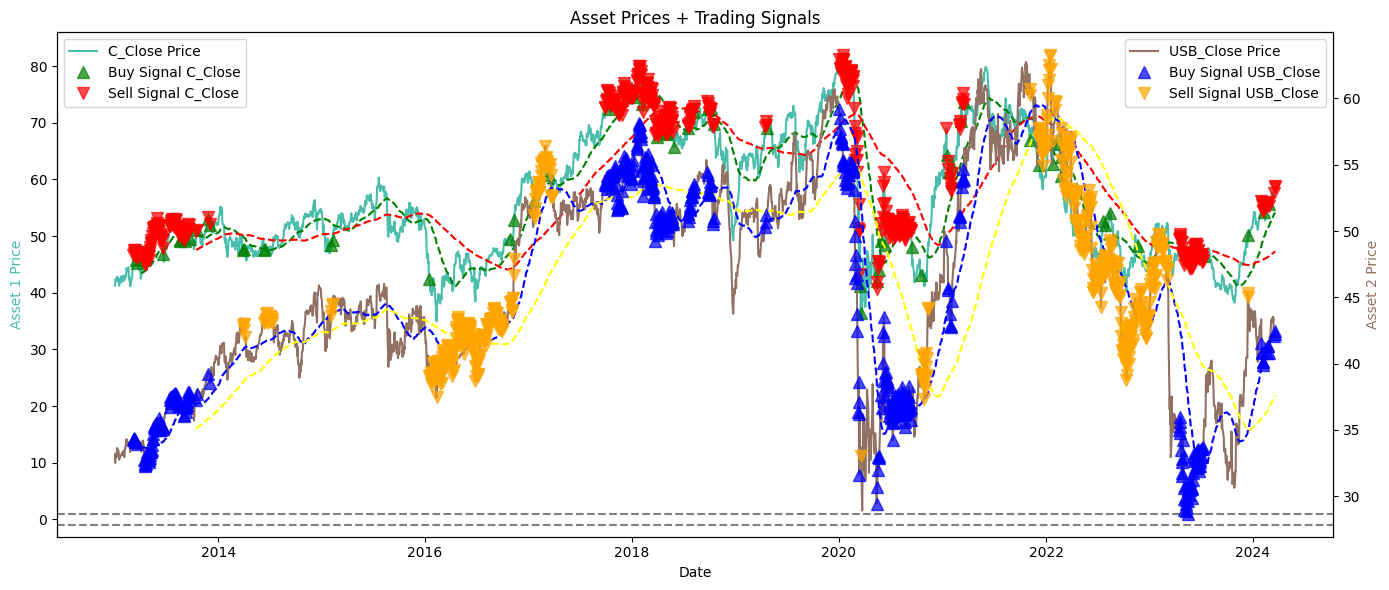

C_Close
ONB_Close
Sharpe Ratio for Total Portfolio: -7.4970255437811355
Number of days =  4092
CAGR = 9.517%
               asset1  holdings1          cash1   total asset1  return1  \
Date                                                                      
2024-03-13  57.759998        0.0  173236.575241  173236.575241      0.0   
2024-03-14  57.090000        0.0  173236.575241  173236.575241      0.0   
2024-03-15  57.610001        0.0  173236.575241  173236.575241      0.0   
2024-03-18  58.630001        0.0  173236.575241  173236.575241      0.0   
2024-03-19  58.849998        0.0  173236.575241  173236.575241      0.0   

            positions1     asset2  holdings2          cash2   total asset2  \
Date                                                                         
2024-03-13         0.0  16.590000        0.0  103866.118347  103866.118347   
2024-03-14         0.0  16.190001        0.0  103866.118347  103866.118347   
2024-03-15         0.0  16.400000        0.0  103866.

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


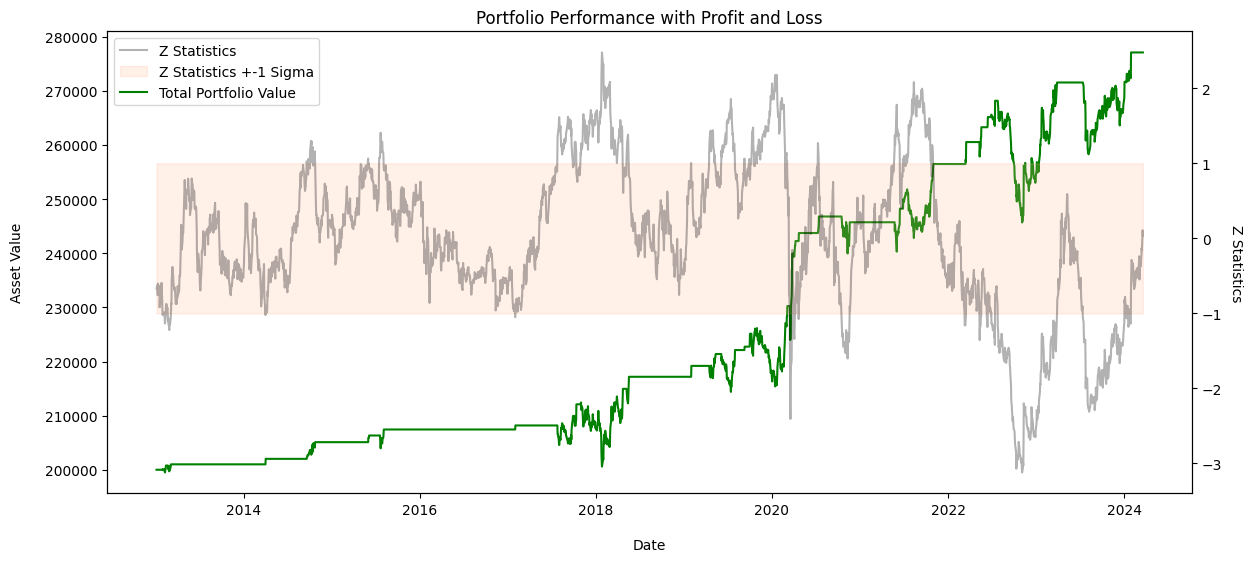

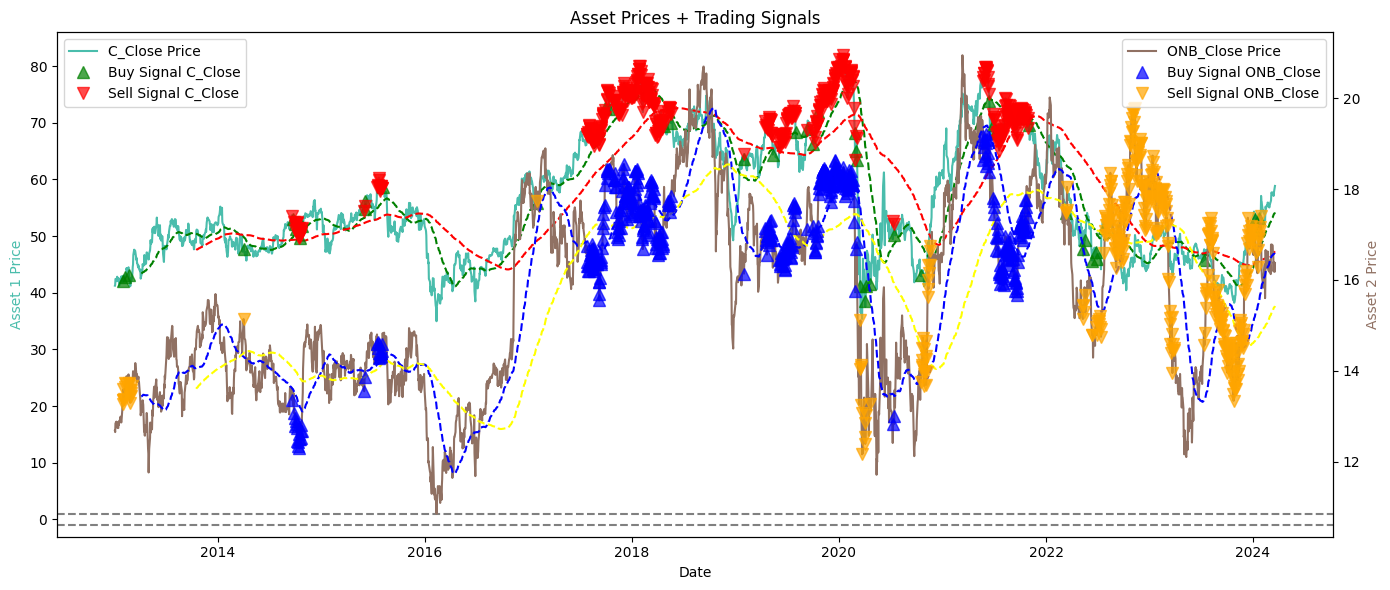

MS_Close
BLK_Close


<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


Sharpe Ratio for Total Portfolio: -8.349196073867143
Number of days =  4092
CAGR = 8.000%
               asset1  holdings1          cash1   total asset1  return1  \
Date                                                                      
2024-03-13  89.349998        0.0  183803.603479  183803.603479      0.0   
2024-03-14  89.099998        0.0  183803.603479  183803.603479      0.0   
2024-03-15  88.379997        0.0  183803.603479  183803.603479      0.0   
2024-03-18  87.959999        0.0  183803.603479  183803.603479      0.0   
2024-03-19  88.300003        0.0  183803.603479  183803.603479      0.0   

            positions1      asset2  holdings2         cash2  total asset2  \
Date                                                                        
2024-03-13         0.0  825.989990        0.0  53166.677277  53166.677277   
2024-03-14         0.0  808.799988        0.0  53166.677277  53166.677277   
2024-03-15         0.0  802.520020        0.0  53166.677277  53166.677277   

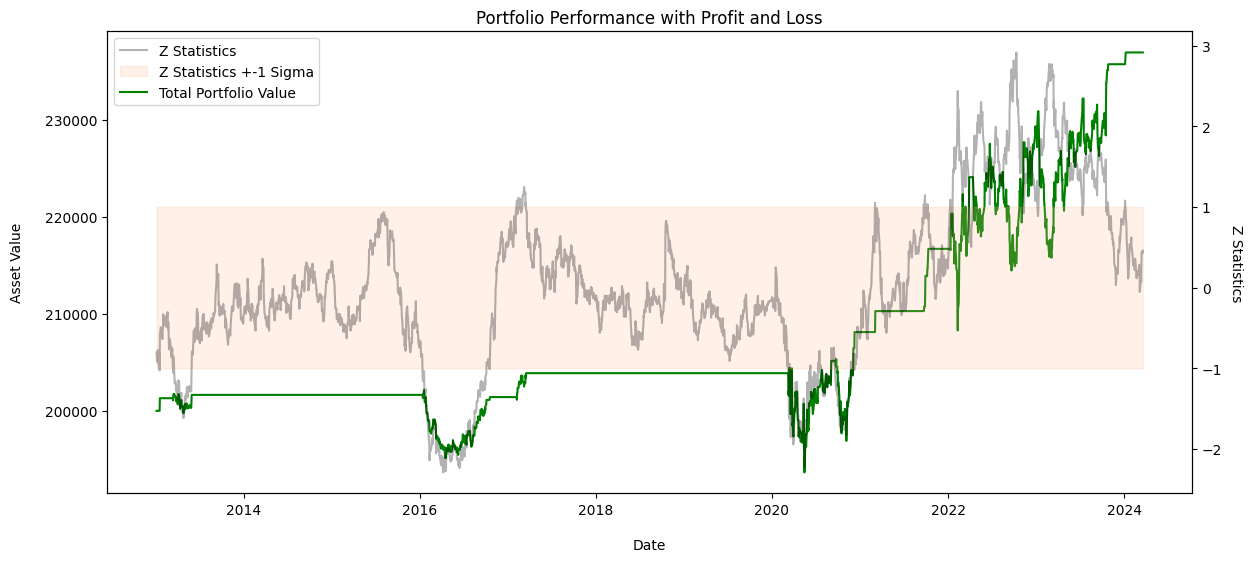

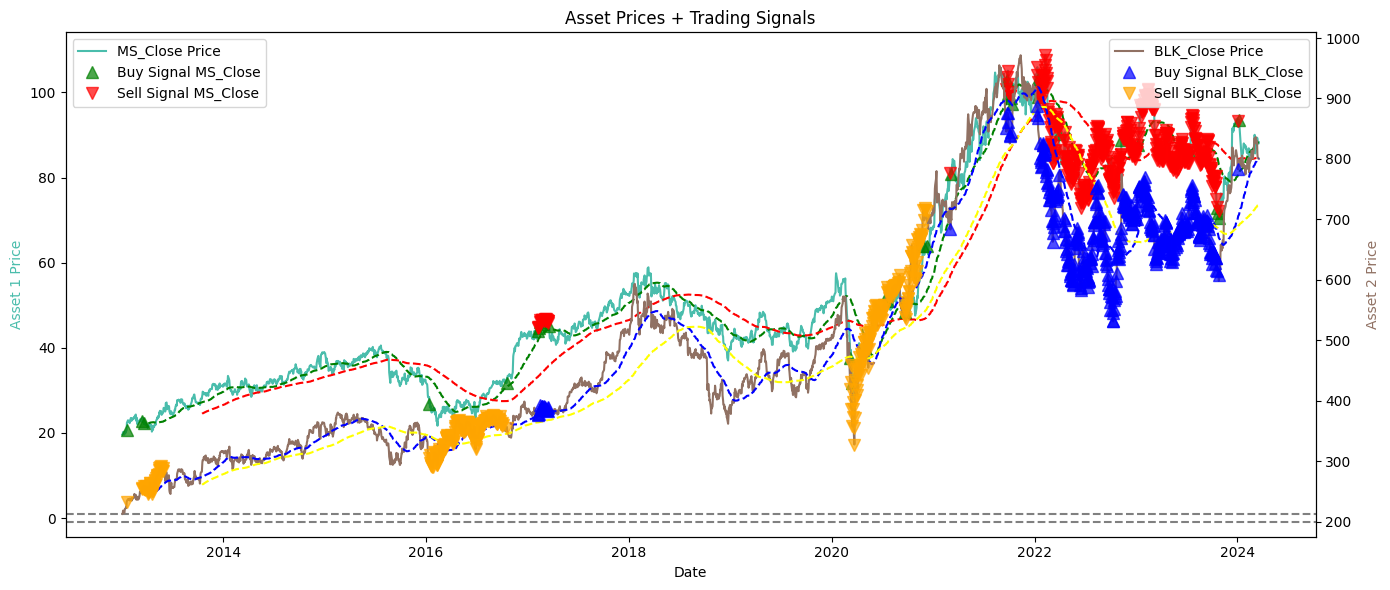

PNC_Close
FITB_Close
Sharpe Ratio for Total Portfolio: -6.251166918849063
Number of days =  4092
CAGR = 7.299%
                asset1     holdings1          cash1  total asset1   return1  \
Date                                                                          
2024-03-13  152.720001 -67349.520538  124550.469193  57200.948654  0.000000   
2024-03-14  148.490005      0.000000   59066.376770  59066.376770  0.032612   
2024-03-15  148.779999 -65611.979462  124678.356232  59066.376770  0.000000   
2024-03-18  149.600006      0.000000   58704.753540  58704.753540 -0.006122   
2024-03-19  150.000000 -66150.000000  124854.753540  58704.753540  0.000000   

            positions1     asset2     holdings2          cash2   total asset2  \
Date                                                                            
2024-03-13        -1.0  36.230000  71807.859093   90347.673458  162155.532551   
2024-03-14         1.0  35.419998      0.000000  160550.109829  160550.109829   
2024-03-15 

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


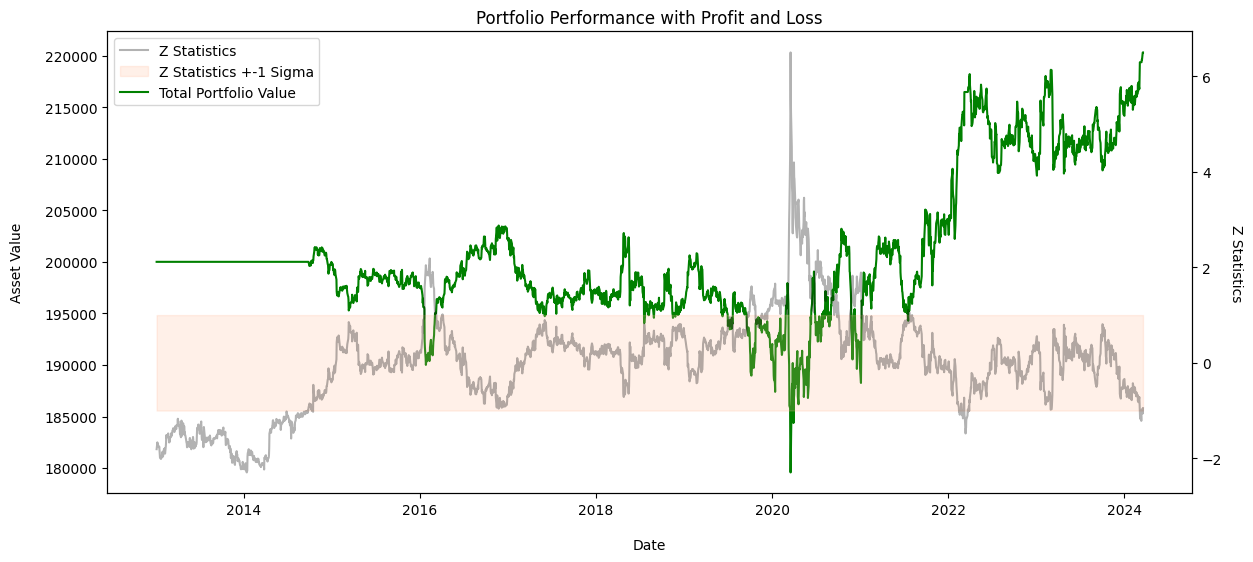

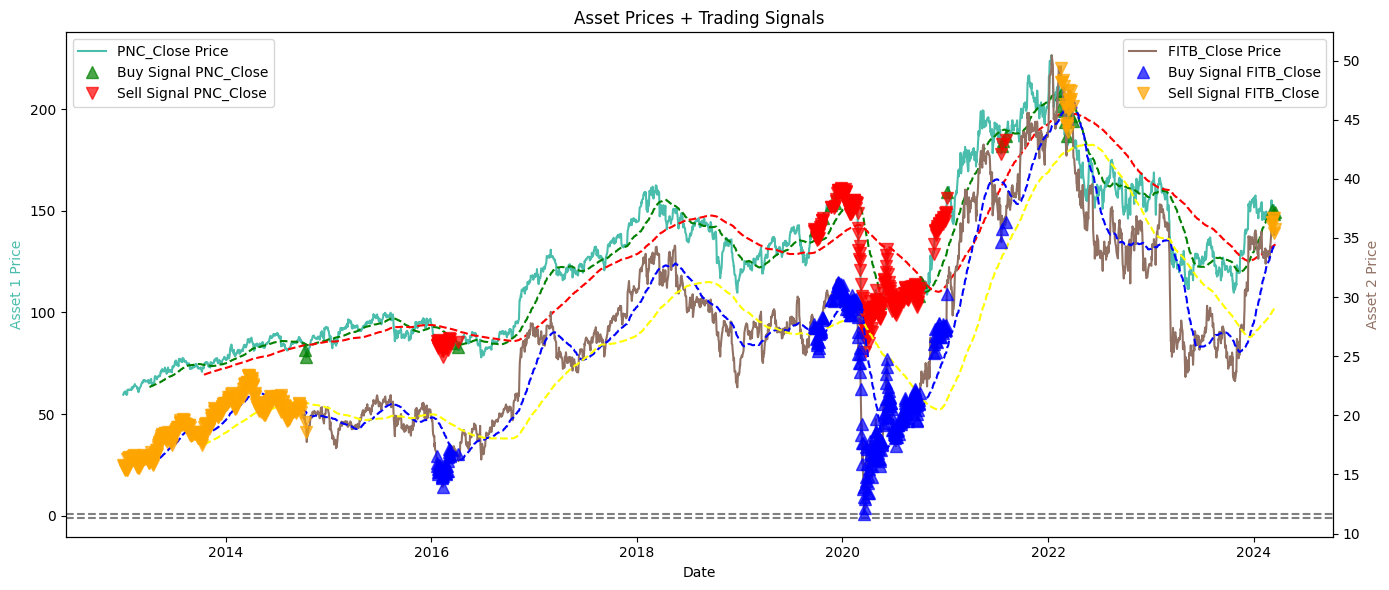

BK_Close
HBAN_Close
Sharpe Ratio for Total Portfolio: -4.11689109298769
Number of days =  4092
CAGR = 9.988%
               asset1  holdings1          cash1   total asset1  return1  \
Date                                                                      
2024-03-13  55.279999        0.0  153772.526951  153772.526951      0.0   
2024-03-14  54.450001        0.0  153772.526951  153772.526951      0.0   
2024-03-15  54.410000        0.0  153772.526951  153772.526951      0.0   
2024-03-18  54.939999        0.0  153772.526951  153772.526951      0.0   
2024-03-19  55.105000        0.0  153772.526951  153772.526951      0.0   

            positions1  asset2  holdings2          cash2   total asset2  \
Date                                                                      
2024-03-13         0.0  13.440        0.0  136981.431778  136981.431778   
2024-03-14         0.0  13.060        0.0  136981.431778  136981.431778   
2024-03-15         0.0  13.050        0.0  136981.431778  136981.

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


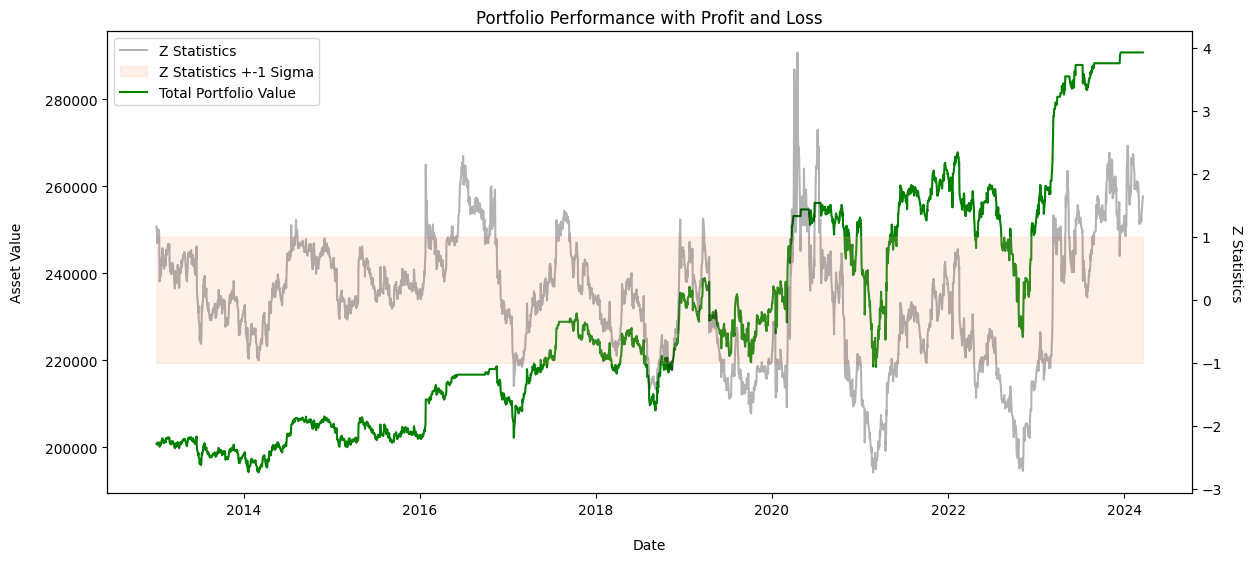

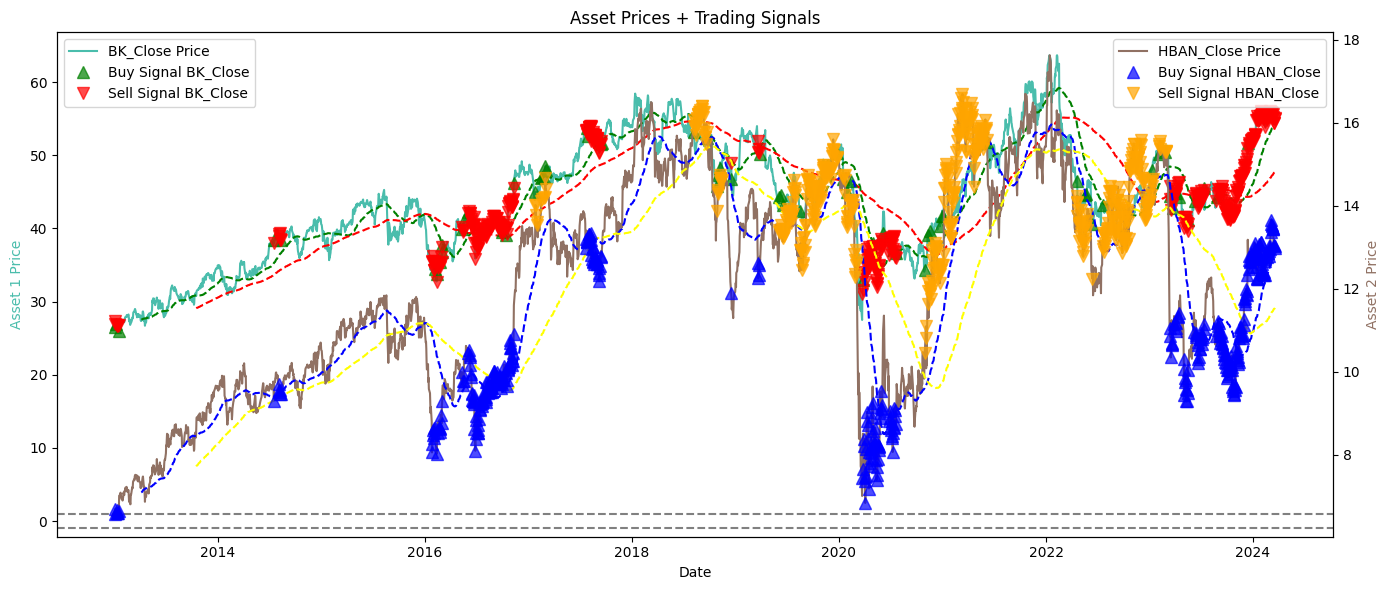

STT_Close
TCBI_Close
Sharpe Ratio for Total Portfolio: -3.208079240355595
Number of days =  4092
CAGR = 8.824%
               asset1     holdings1          cash1  total asset1   return1  \
Date                                                                         
2024-03-13  72.849998 -64617.948647  142593.733639  77975.784992 -0.003853   
2024-03-14  71.860001 -63739.820541  142593.733639  78853.913097  0.011262   
2024-03-15  72.500000 -64307.500000  142593.733639  78286.233639 -0.007199   
2024-03-18  72.489998 -64298.628105  142593.733639  78295.105534  0.000113   
2024-03-19  72.385002 -64205.496895  142593.733639  78388.236744  0.001189   

            positions1     asset2     holdings2          cash2   total asset2  \
Date                                                                            
2024-03-13         0.0  59.189999  57828.628658  121562.365477  179390.994135   
2024-03-14         0.0  58.080002  56744.161789  121562.365477  178306.527266   
2024-03-15        

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


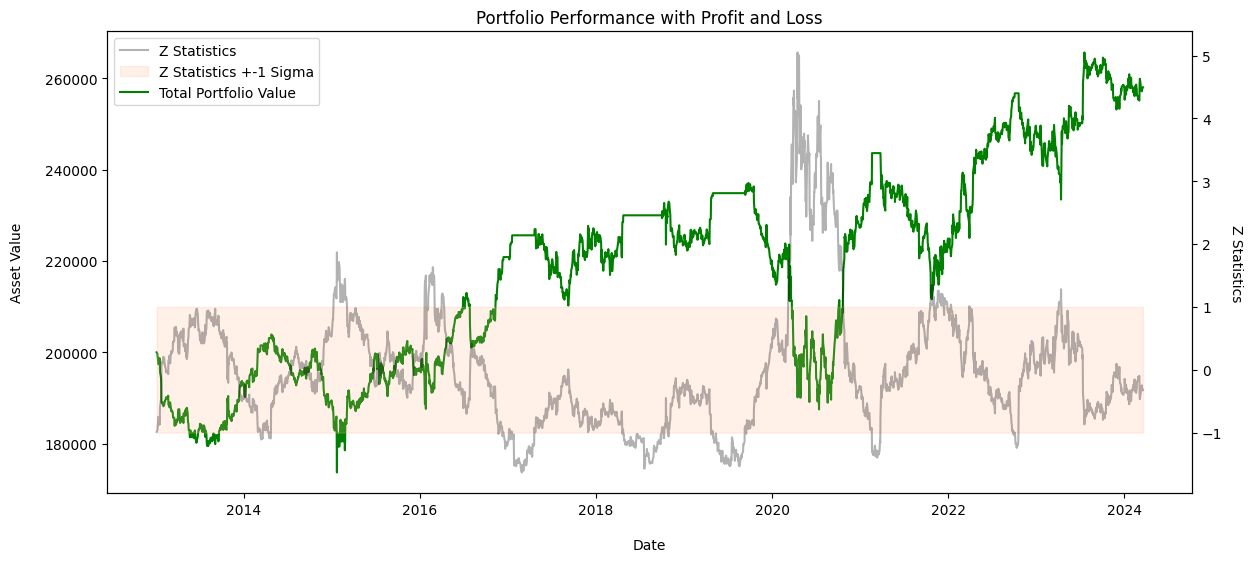

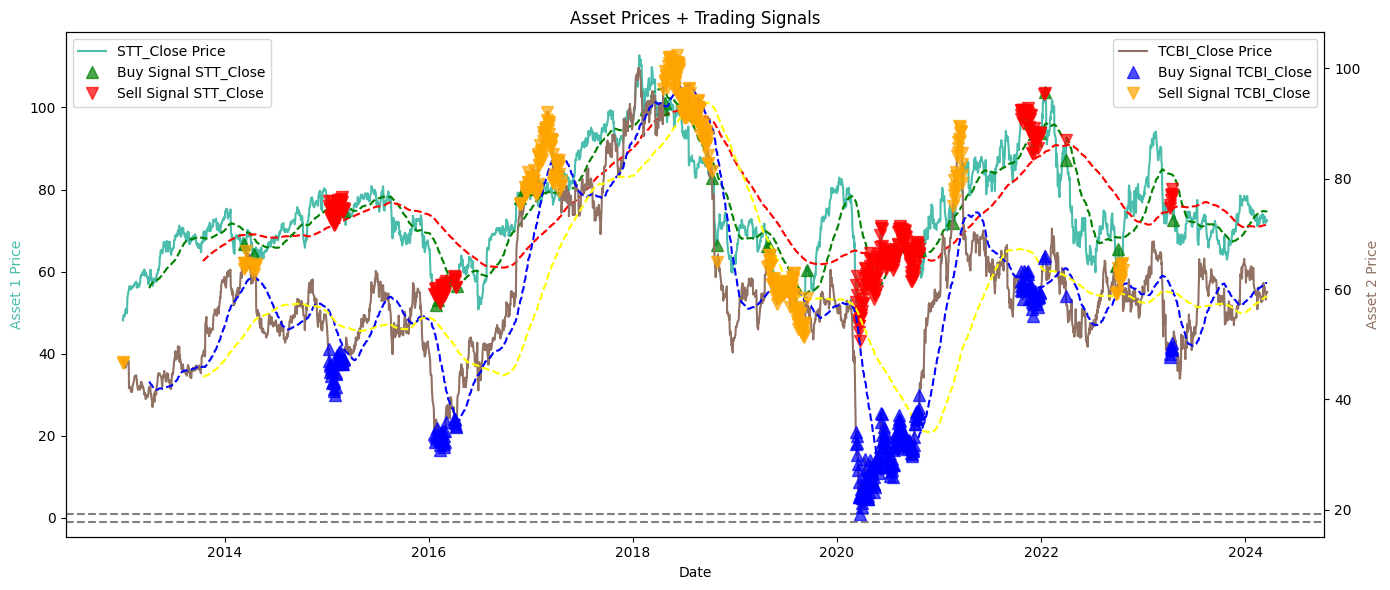

KEY_Close
TFC_Close
Sharpe Ratio for Total Portfolio: -5.431753985592399


<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


Number of days =  4092
CAGR = 8.723%
            asset1      holdings1          cash1   total asset1   return1  \
Date                                                                        
2024-03-13  14.930 -110541.722260  322045.968897  211504.246637 -0.004183   
2024-03-14  14.420 -106765.680565  322045.968897  215280.288332  0.017853   
2024-03-15  14.480 -107209.916611  322045.968897  214836.052286 -0.002064   
2024-03-18  14.440 -106913.756893  322045.968897  215132.212004  0.001379   
2024-03-19  14.425 -106802.701412  322045.968897  215243.267485  0.000516   

            positions1     asset2      holdings2         cash2  total asset2  \
Date                                                                           
2024-03-13         0.0  36.450001  108110.702263 -65310.003325  42800.698938   
2024-03-14         0.0  35.020000  103869.321358 -65310.003325  38559.318033   
2024-03-15         0.0  34.860001  103394.761810 -65310.003325  38084.758486   
2024-03-18         0.0 

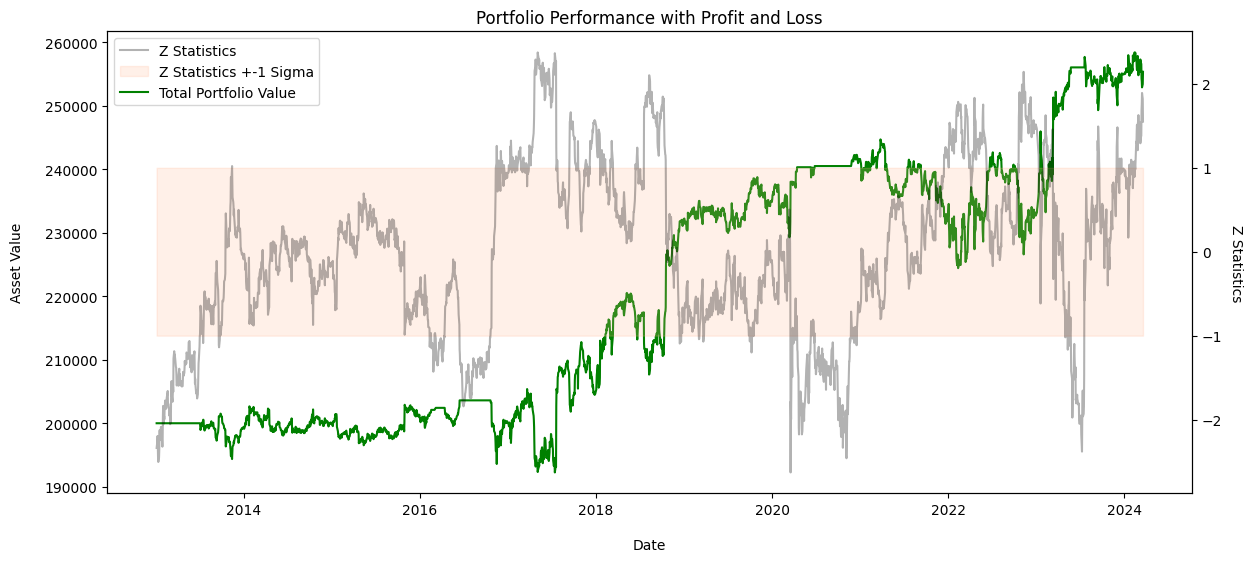

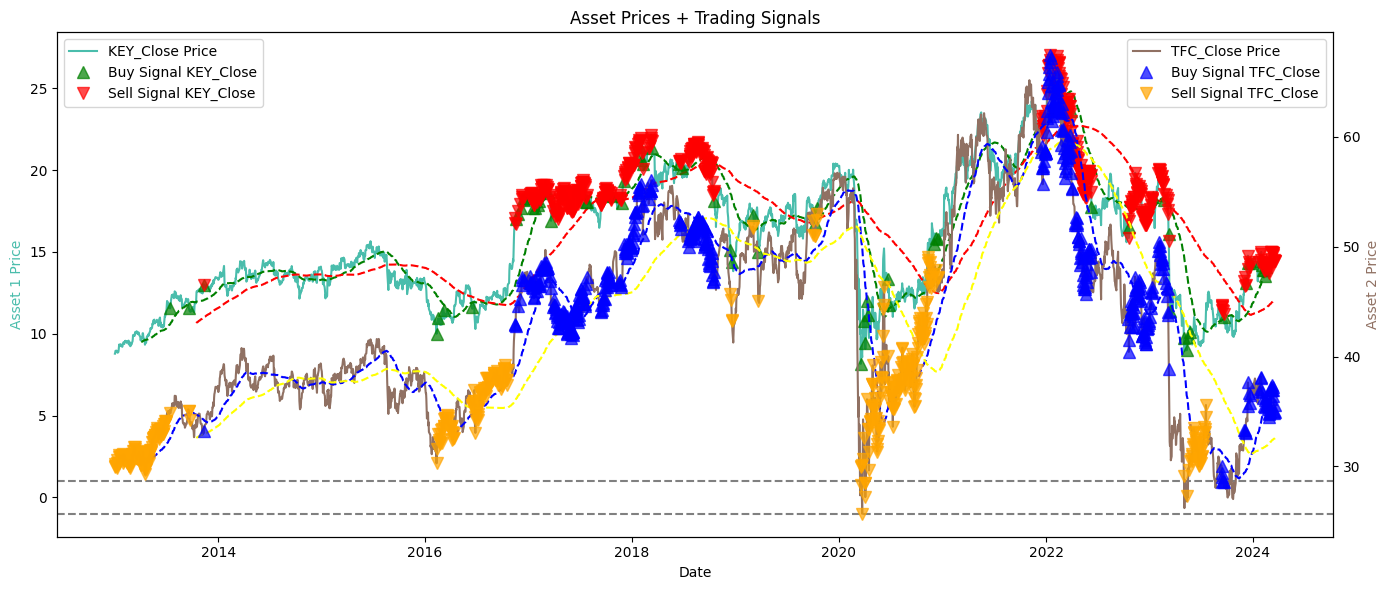

RF_Close
CFR_Close
Sharpe Ratio for Total Portfolio: -4.23849160785783
Number of days =  4092
CAGR = 8.836%
               asset1      holdings1          cash1   total asset1   return1  \
Date                                                                           
2024-03-13  19.400000 -152677.996998  269716.546698  117038.549700 -0.003351   
2024-03-14  18.889999 -148664.295197  269716.546698  121052.251501  0.034294   
2024-03-15  19.049999 -149923.493996  269716.546698  119793.052702 -0.010402   
2024-03-18  19.180000 -150946.602402  269716.546698  118769.944296 -0.008541   
2024-03-19  19.184999 -150985.945797  269716.546698  118730.600901 -0.000331   

            positions1      asset2      holdings2        cash2   total asset2  \
Date                                                                            
2024-03-13         0.0  107.750000  135765.000000  6841.912689  142606.912689   
2024-03-14         0.0  105.720001  133207.201538  6841.912689  140049.114227   
2024-03

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


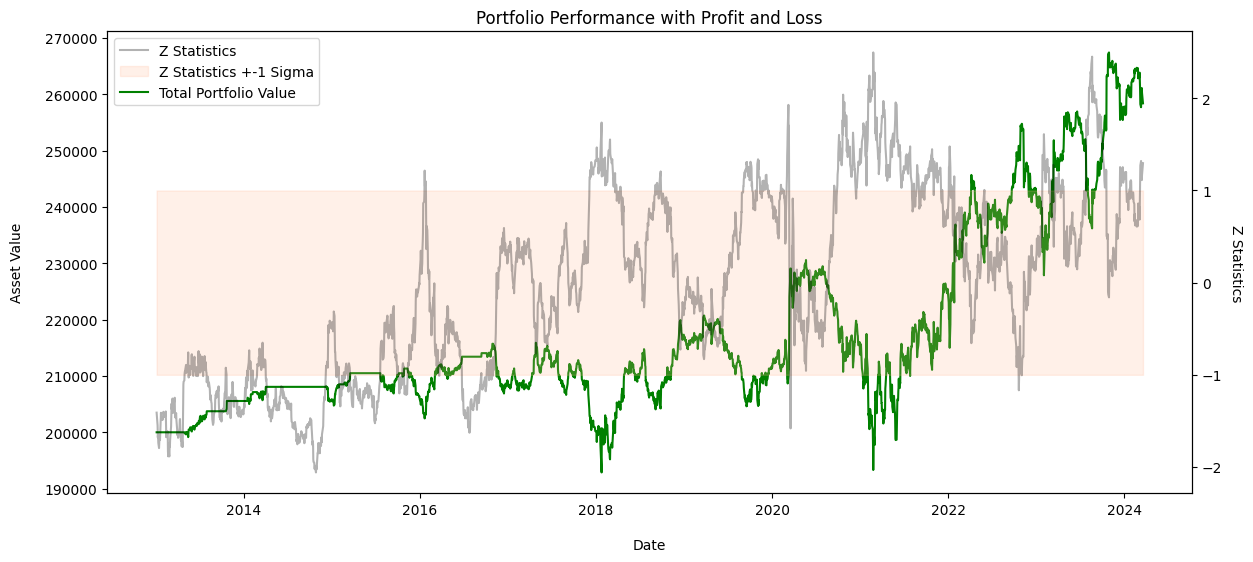

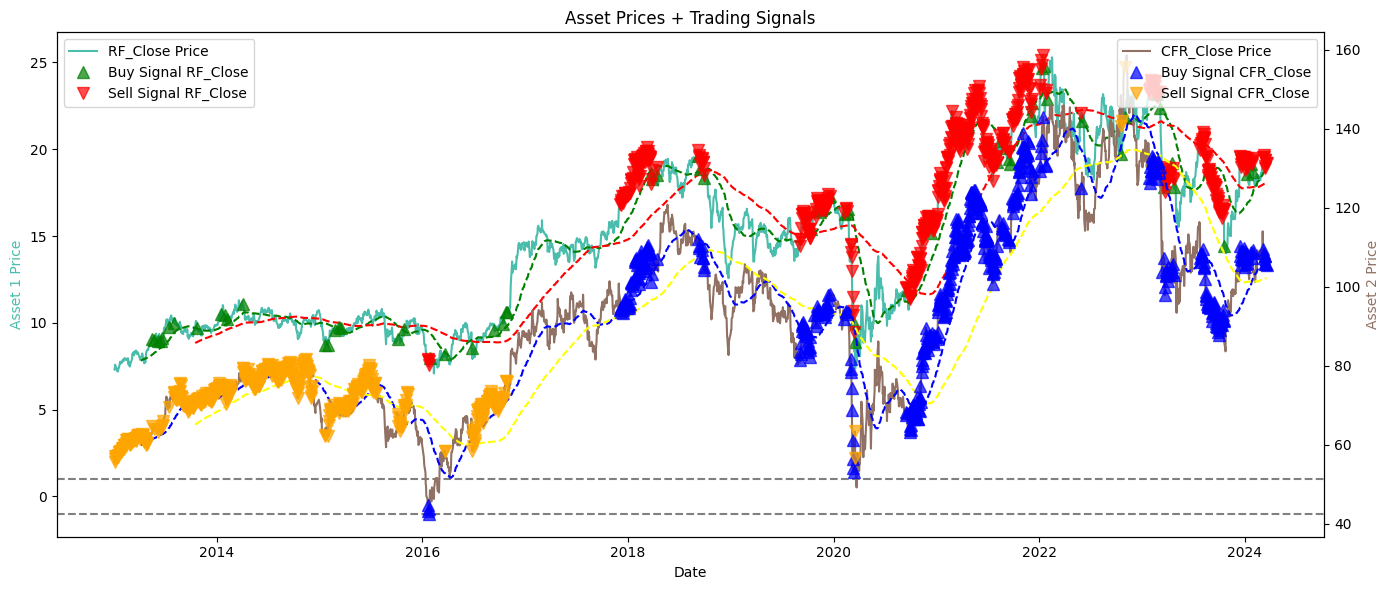

HBAN_Close
MTB_Close
Sharpe Ratio for Total Portfolio: -4.073477619265446
Number of days =  4092
CAGR = 7.769%
            asset1     holdings1          cash1  total asset1   return1  \
Date                                                                      
2024-03-13  13.440 -76231.677620  148835.931576  72604.253956  0.000000   
2024-03-14  13.060 -74076.322380  148835.931576  74759.609196  0.029686   
2024-03-15  13.050 -74019.601082  148835.931576  74816.330494  0.000759   
2024-03-18  13.020 -73849.442596  148835.931576  74986.488979  0.002274   
2024-03-19  12.985 -73650.918053  148835.931576  75185.013523  0.002647   

            positions1      asset2     holdings2         cash2   total asset2  \
Date                                                                            
2024-03-13         0.0  143.190002  72740.521240  85207.030853  157947.552094   
2024-03-14         0.0  140.339996  71292.718140  85207.030853  156499.748993   
2024-03-15         0.0  140.529999  713

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


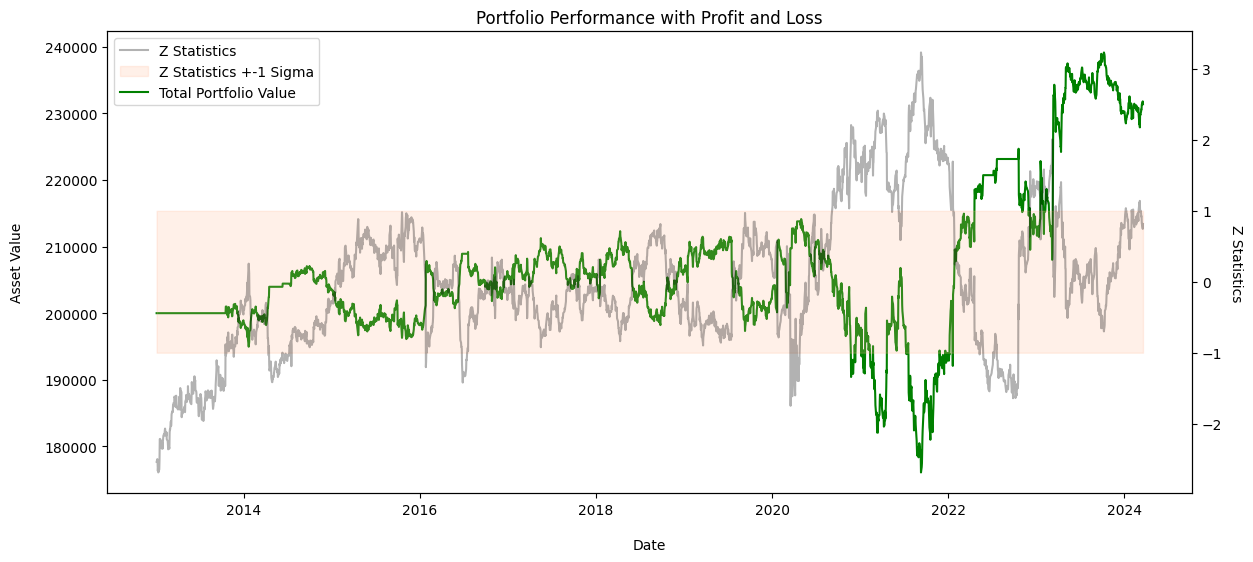

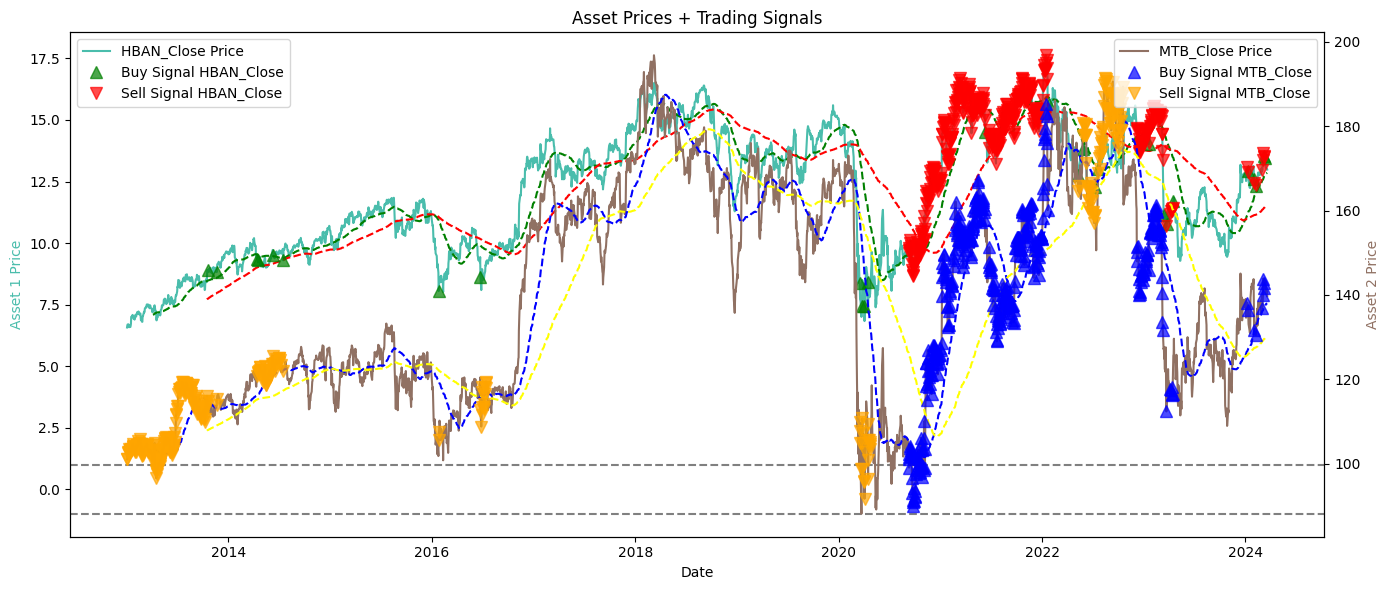

HBAN_Close
FULT_Close
Sharpe Ratio for Total Portfolio: -4.299146829170334
Number of days =  4092
CAGR = 9.061%
            asset1     holdings1          cash1   total asset1   return1  \
Date                                                                       
2024-03-13  13.440 -76231.677620  196140.385395  119908.707775  0.000000   
2024-03-14  13.060 -74076.322380  196140.385395  122064.063015  0.017975   
2024-03-15  13.050 -74019.601082  196140.385395  122120.784313  0.000465   
2024-03-18  13.020 -73849.442596  196140.385395  122290.942799  0.001393   
2024-03-19  12.985 -73650.918053  196140.385395  122489.467342  0.001623   

            positions1  asset2     holdings2         cash2   total asset2  \
Date                                                                        
2024-03-13         0.0   15.23  77307.477676  65432.428188  142739.905865   
2024-03-14         0.0   14.80  75124.800968  65432.428188  140557.229156   
2024-03-15         0.0   14.92  75733.920387  6

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


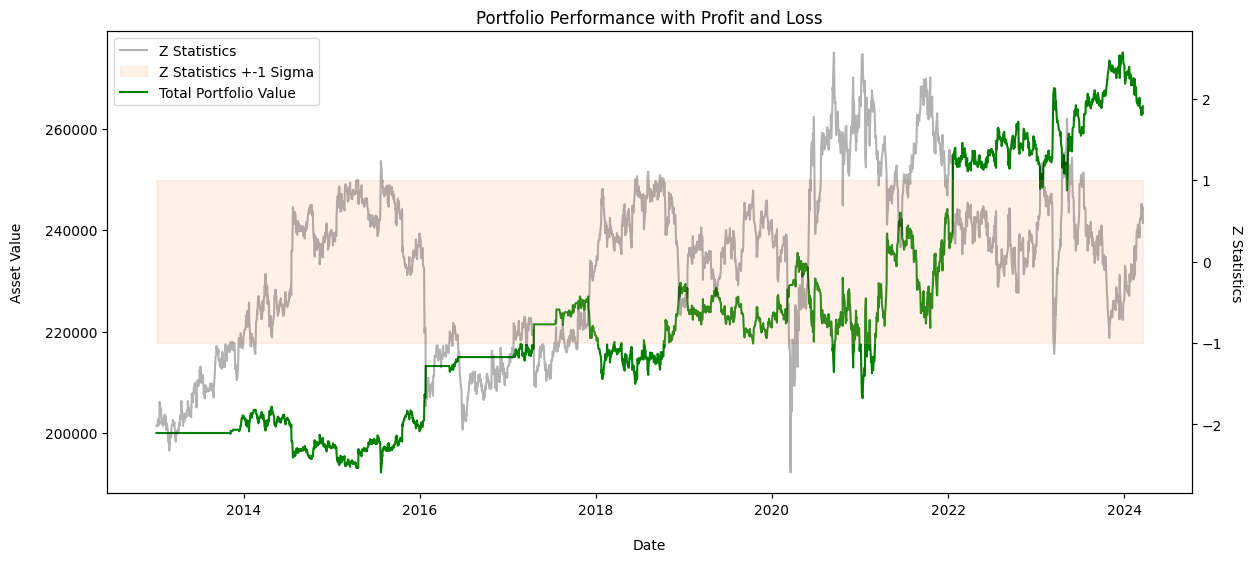

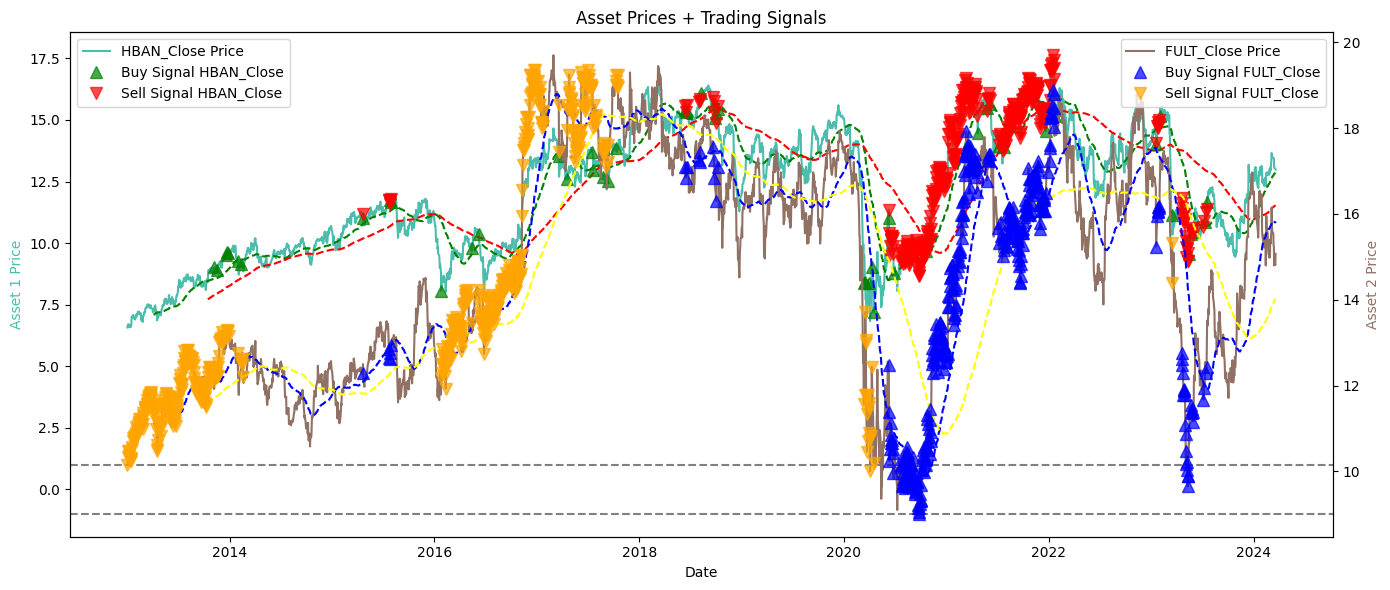

HBAN_Close
ONB_Close
Sharpe Ratio for Total Portfolio: -4.0682326781191955
Number of days =  4092
CAGR = 8.567%
            asset1     holdings1          cash1   total asset1   return1  \
Date                                                                       
2024-03-13  13.440 -76231.677620  218544.792427  142313.114807  0.000000   
2024-03-14  13.060 -74076.322380  218544.792427  144468.470047  0.015145   
2024-03-15  13.050 -74019.601082  218544.792427  144525.191345  0.000393   
2024-03-18  13.020 -73849.442596  218544.792427  144695.349831  0.001177   
2024-03-19  12.985 -73650.918053  218544.792427  144893.874374  0.001372   

            positions1     asset2     holdings2        cash2   total asset2  \
Date                                                                          
2024-03-13         0.0  16.590000  79184.070728  28261.84769  107445.918418   
2024-03-14         0.0  16.190001  77274.872549  28261.84769  105536.720239   
2024-03-15         0.0  16.400000  7827

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


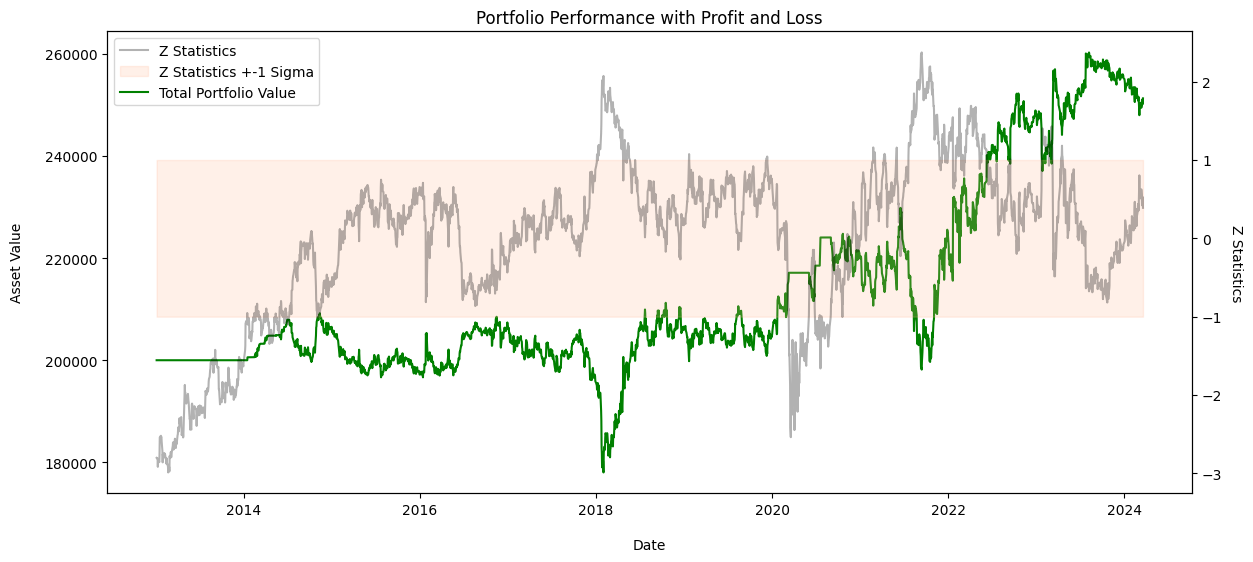

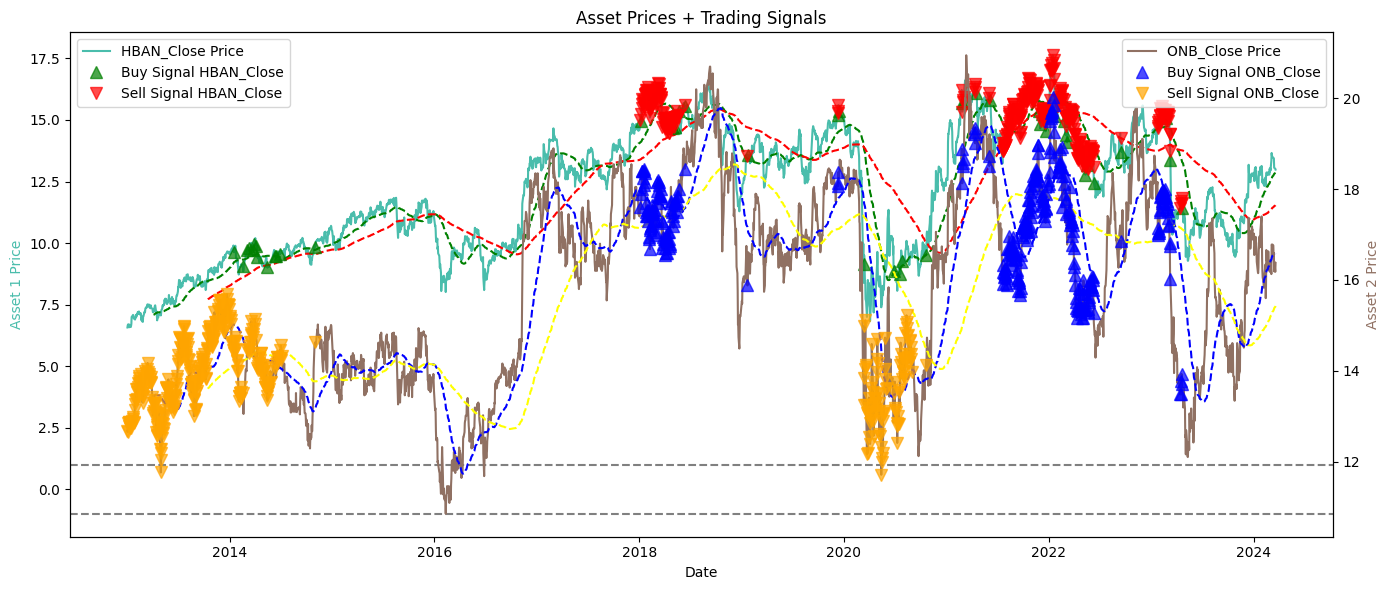

FITB_Close
UMBF_Close
Sharpe Ratio for Total Portfolio: -9.18532220880511
Number of days =  4092
CAGR = 9.518%
               asset1     holdings1          cash1   total asset1   return1  \
Date                                                                          
2024-03-13  36.230000 -71807.859093  270511.459471  198703.600378  0.004609   
2024-03-14  35.419998 -70202.436371  270511.459471  200309.023100  0.008079   
2024-03-15  35.240002 -69845.683327  270511.459471  200665.776144  0.001781   
2024-03-18  35.770000 -70896.140907  270511.459471  199615.318563 -0.005235   
2024-03-19  35.450001 -70261.901512  270511.459471  200249.557959  0.003177   

            positions1     asset2     holdings2        cash2  total asset2  \
Date                                                                         
2024-03-13         0.0  80.500000  72208.500000  5590.767109  77799.267109   
2024-03-14         0.0  79.269997  71105.186989  5590.767109  76695.954098   
2024-03-15         0.0 

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


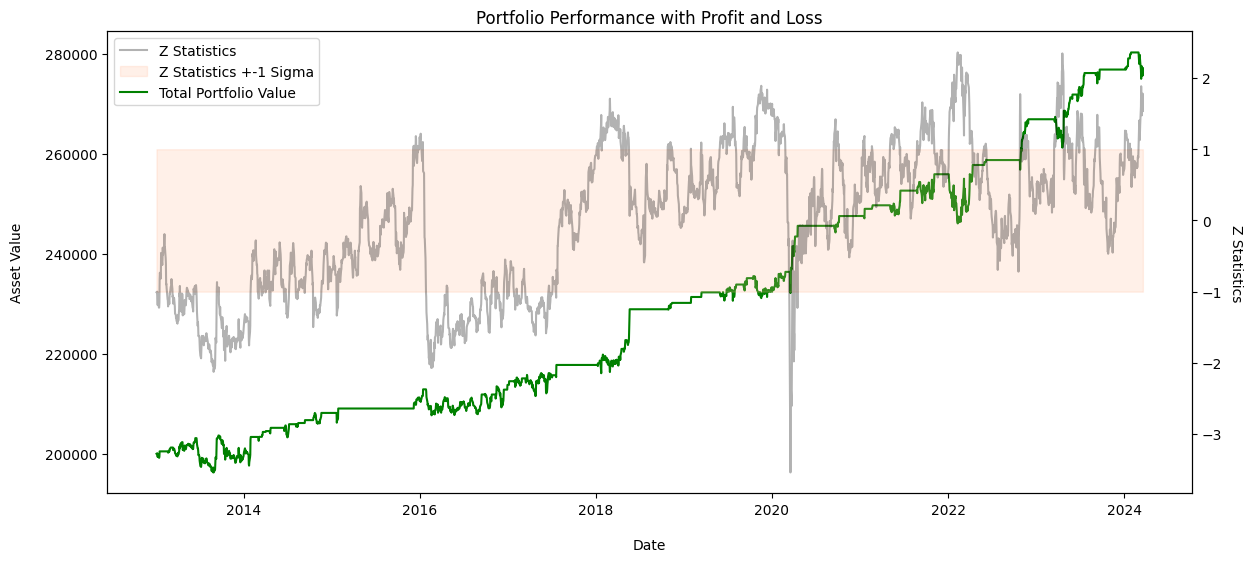

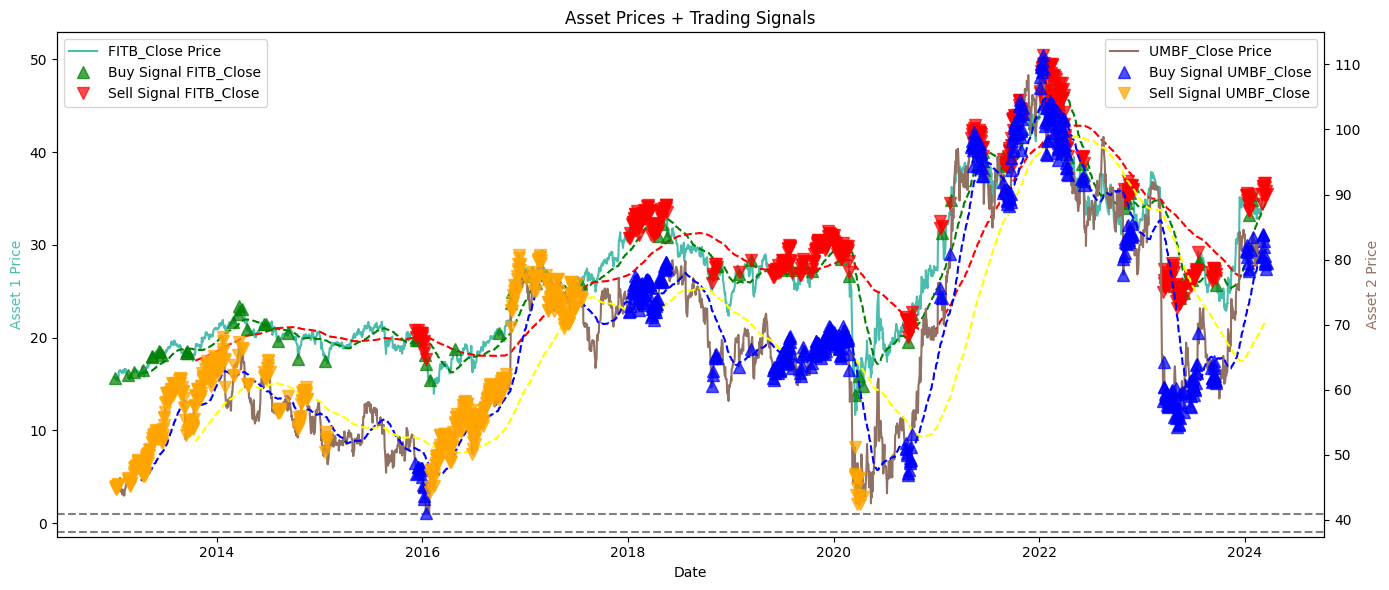

MTB_Close
FULT_Close
Sharpe Ratio for Total Portfolio: -8.993084154410354
Number of days =  4092
CAGR = 10.853%
                asset1  holdings1          cash1   total asset1  return1  \
Date                                                                       
2024-03-13  143.190002        0.0  169916.046356  169916.046356      0.0   
2024-03-14  140.339996        0.0  169916.046356  169916.046356      0.0   
2024-03-15  140.529999        0.0  169916.046356  169916.046356      0.0   
2024-03-18  140.929993        0.0  169916.046356  169916.046356      0.0   
2024-03-19  139.683899        0.0  169916.046356  169916.046356      0.0   

            positions1  asset2  holdings2          cash2   total asset2  \
Date                                                                      
2024-03-13         0.0   15.23        0.0  147511.353416  147511.353416   
2024-03-14         0.0   14.80        0.0  147511.353416  147511.353416   
2024-03-15         0.0   14.92        0.0  147511.35341

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


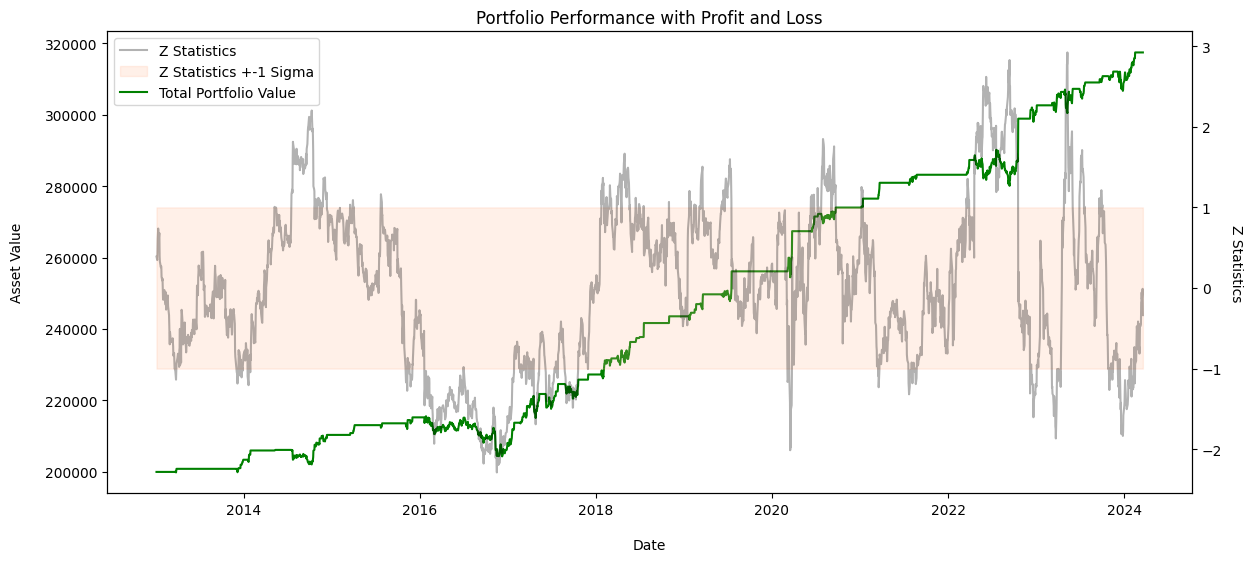

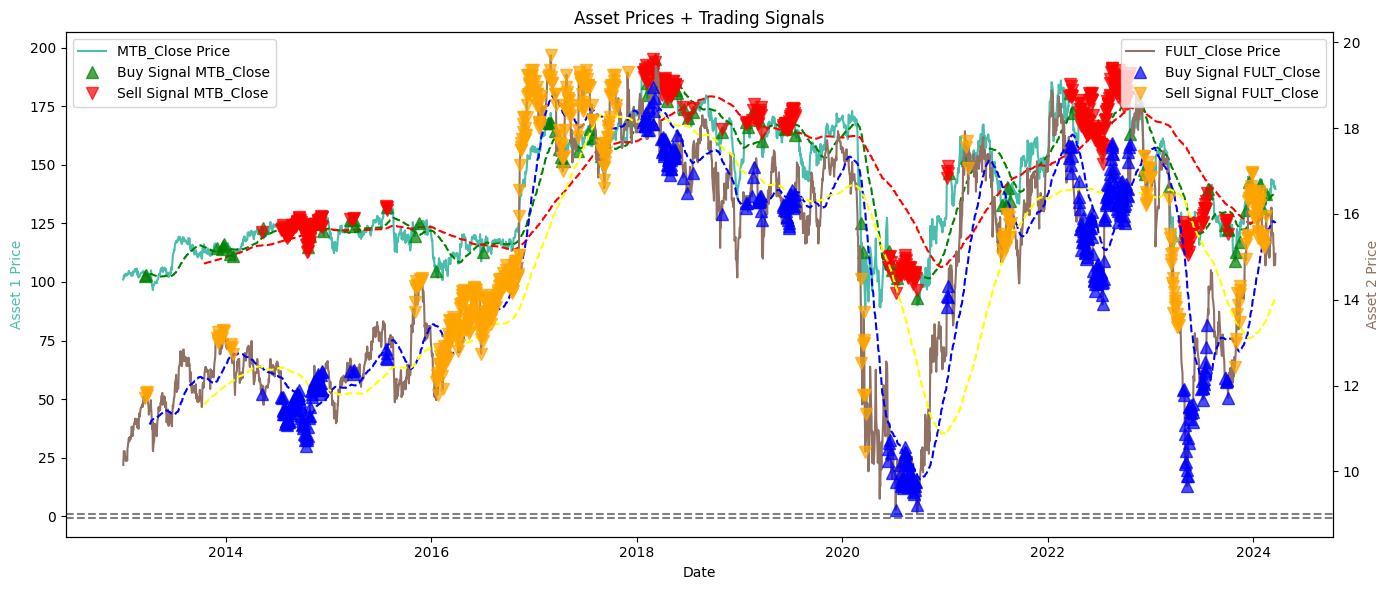

MTB_Close
ONB_Close
Sharpe Ratio for Total Portfolio: -3.5624875997380543
Number of days =  4092
CAGR = 8.973%
                asset1     holdings1          cash1   total asset1   return1  \
Date                                                                           
2024-03-13  143.190002 -72740.521240  206822.254883  134081.733643  0.000189   
2024-03-14  140.339996 -71292.718140  206822.254883  135529.536743  0.010798   
2024-03-15  140.529999 -71389.239380  206822.254883  135433.015503 -0.000712   
2024-03-18  140.929993 -71592.436279  206822.254883  135229.818604 -0.001500   
2024-03-19  139.683899 -70959.420654  206822.254883  135862.834229  0.004681   

            positions1     asset2     holdings2         cash2   total asset2  \
Date                                                                           
2024-03-13         0.0  16.590000  79184.070728  48022.032913  127206.103642   
2024-03-14         0.0  16.190001  77274.872549  48022.032913  125296.905462   
2024-03-

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


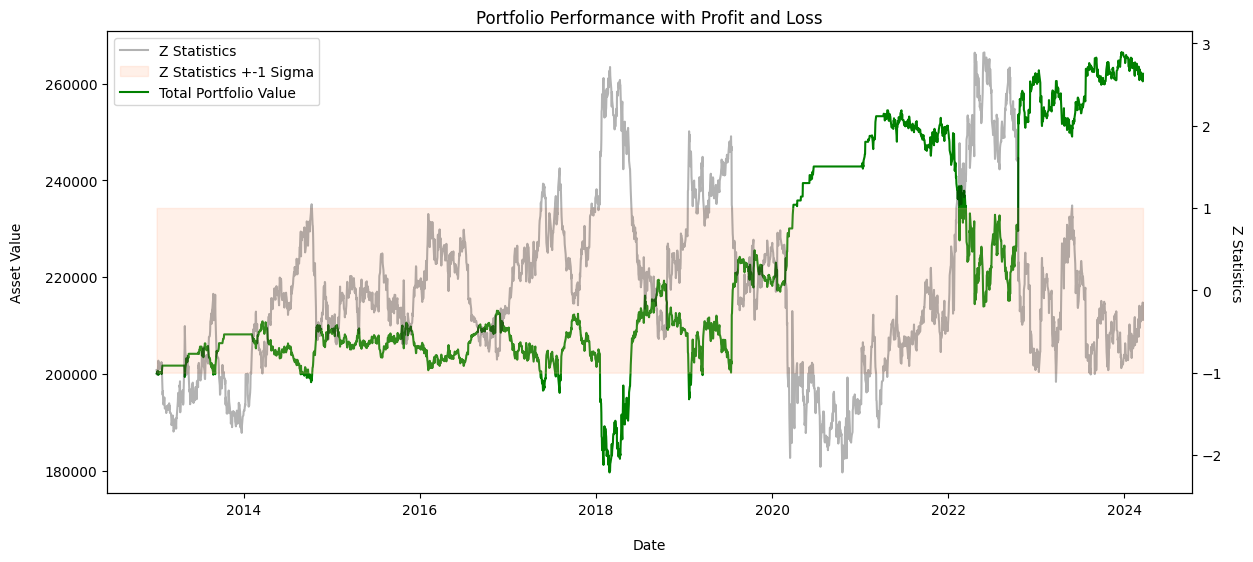

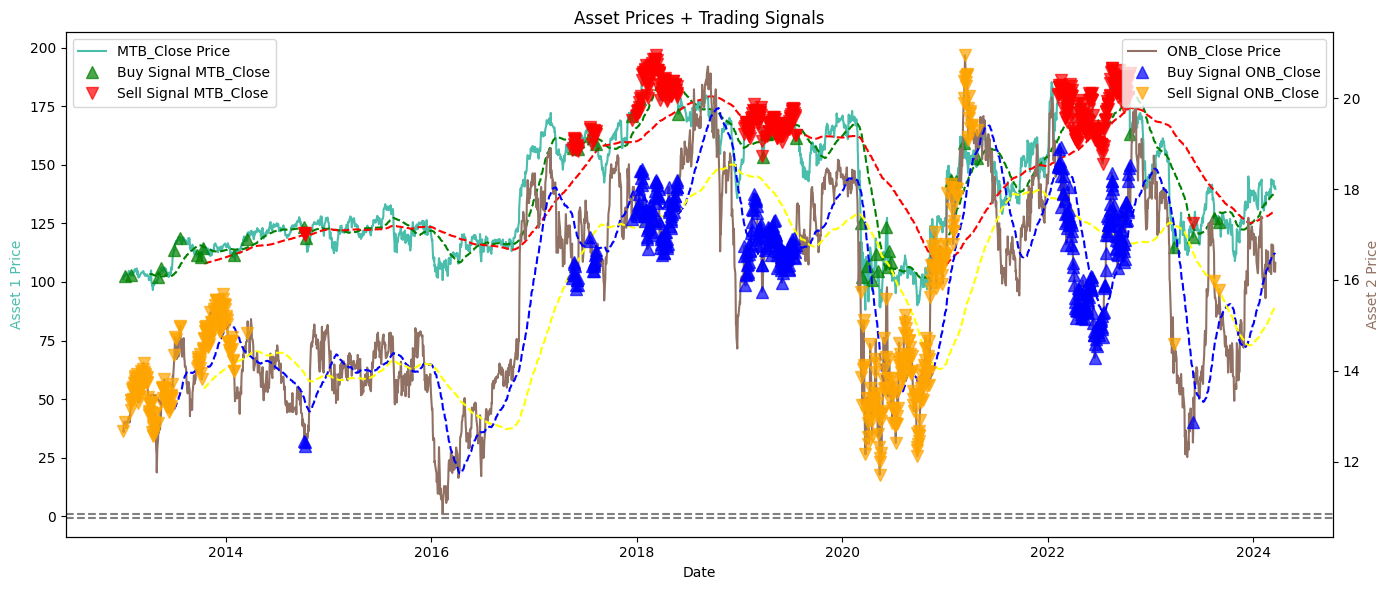

ZION_Close
GBCI_Close
Sharpe Ratio for Total Portfolio: -3.721226532047991
Number of days =  4092
CAGR = 9.192%
               asset1     holdings1          cash1   total asset1   return1  \
Date                                                                          
2024-03-13  41.070000  55239.149590  130222.118292  185461.267881  0.001234   
2024-03-14  39.799999  53530.998974  130222.118292  183753.117266 -0.009210   
2024-03-15  39.790001  53517.551231  130222.118292  183739.669523 -0.000073   
2024-03-18  39.730000  53436.849384  130222.118292  183658.967676 -0.000439   
2024-03-19  39.775002  53497.377052  130222.118292  183719.495344  0.000330   

            positions1     asset2     holdings2          cash2  total asset2  \
Date                                                                           
2024-03-13         0.0  39.509998 -59383.527477  140596.027477  81212.500000   
2024-03-14         0.0  37.700001 -56663.101147  140596.027477  83932.926331   
2024-03-15    

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


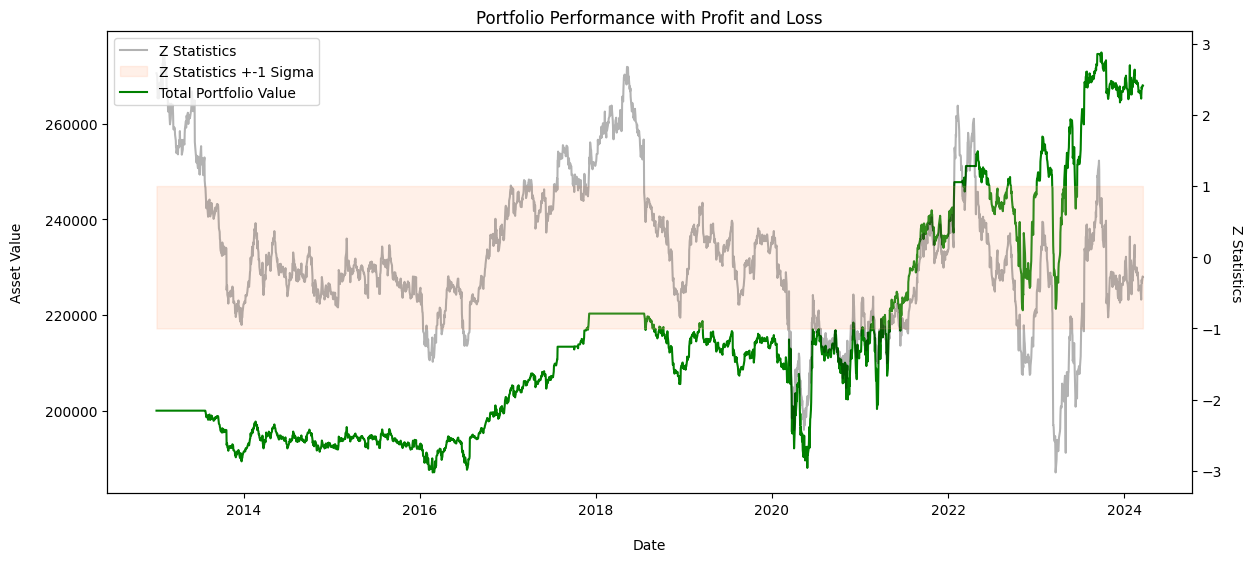

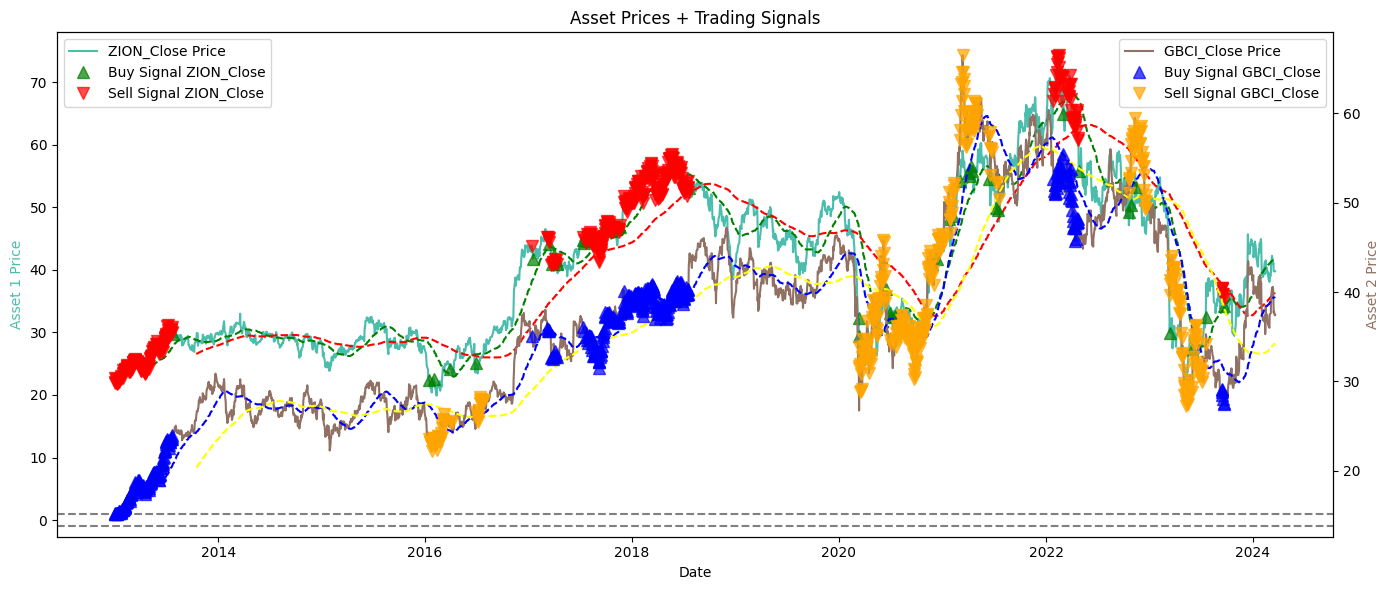

SBCF_Close
GBCI_Close
Sharpe Ratio for Total Portfolio: -10.902535637265682
Number of days =  4092
CAGR = 8.042%
               asset1  holdings1          cash1   total asset1  return1  \
Date                                                                      
2024-03-13  24.450001        0.0  124829.544592  124829.544592      0.0   
2024-03-14  23.610001        0.0  124829.544592  124829.544592      0.0   
2024-03-15  23.980000        0.0  124829.544592  124829.544592      0.0   
2024-03-18  23.799999        0.0  124829.544592  124829.544592      0.0   
2024-03-19  23.940001        0.0  124829.544592  124829.544592      0.0   

            positions1     asset2  holdings2          cash2   total asset2  \
Date                                                                         
2024-03-13         0.0  39.509998        0.0  113196.338165  113196.338165   
2024-03-14         0.0  37.700001        0.0  113196.338165  113196.338165   
2024-03-15         0.0  37.900002        0.0  113

<ipython-input-13-ab74d3c918ba>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


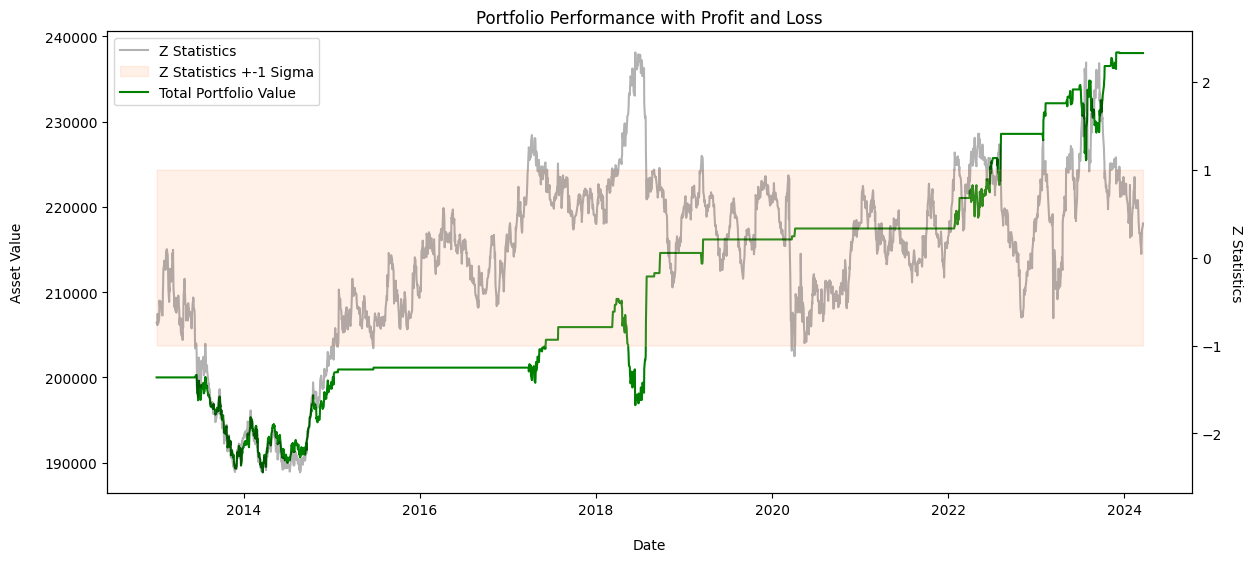

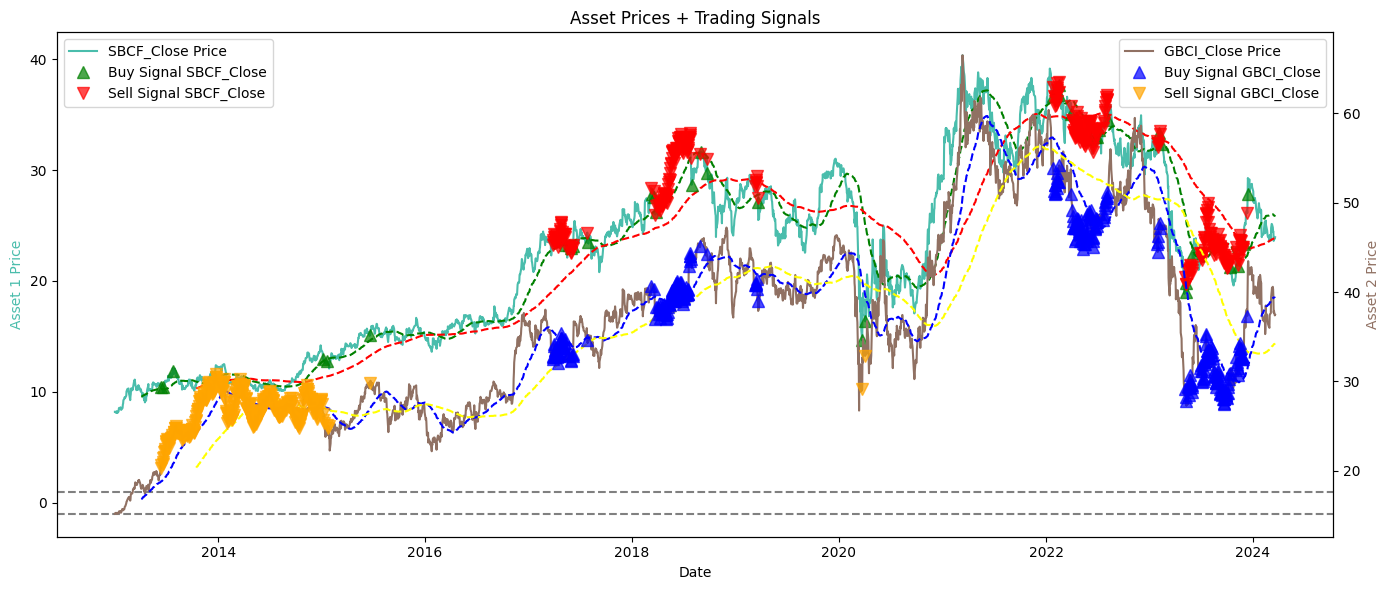

In [ ]:
# calculate z-score
def zscore(series):
 return (series - series.mean()) / np.std(series)
# create a dataframe for trading signals

#receives the list of the best pairs calcuated int he last section.
def plot_relationships(best_value, asset1, asset2):

    # visualize trading signals and position
    fig=plt.figure(figsize=(14,6))
    bx = fig.add_subplot(111)
    bx2 = bx.twinx()


    #plot two different assets
    l1, = bx.plot(signals['asset1'], c='#4abdac', label= "asset 1")
    l2, = bx2.plot(signals['asset2'], c='#907163', label = "asset 2")

    bx.plot(signals['65_MA_asset1'], label='Asset 1 65-MA', linestyle='--', color='green')
    bx2.plot(signals['65_MA_asset2'], label='Asset 2 65-MA', linestyle='--', color='blue')

    bx.plot(signals['200_MA_asset1'], label='Asset 1 200-MA', linestyle='--', color='red')
    bx2.plot(signals['200_MA_asset2'], label='Asset 2 200-MA', linestyle='--', color='yellow')

    #To have all signals uncomment this:
    u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='green',alpha=0.7, label = 'Buy Signal Asset 1')
    d1, = bx.plot(signals['asset1'][signals['signals1'] == -1], lw=0, marker='v', markersize=8, c='red', alpha=0.7, label='Sell Signal Asset 1')
    u2, = bx2.plot(signals['asset2'][signals['signals2'] == 1], lw=0, marker='^', markersize=8, c='blue', alpha=0.7, label='Buy Signal Asset 2')
    d2, = bx2.plot(signals['asset2'][signals['signals2'] == -1], lw=0, marker='v', markersize=8, c='orange', alpha=0.7, label='Sell Signal Asset 2')

    # # plot when there are opposing signals
    # u1, = bx.plot(opposing_signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='green', alpha=0.7, label='Buy Signal Asset 1')
    # d1, = bx.plot(opposing_signals['asset1'][signals['positions1'] == -1], lw=0, marker='v', markersize=8, c='red', alpha=0.7, label='Sell Signal Asset 1')
    # u2, = bx2.plot(opposing_signals['asset2'][signals['positions2'] == 1], lw=0, marker='^', markersize=8, c='blue', alpha=0.7, label='Buy Signal Asset 2')
    # d2, = bx2.plot(opposing_signals['asset2'][signals['positions2'] == -1], lw=0, marker='v', markersize=8, c='orange', alpha=0.7, label='Sell Signal Asset 2')

    bx.axhline(y=signals['z upper limit'][0], color='gray', linestyle='--', label='Z Upper Limit')
    bx.axhline(y=signals['z lower limit'][0], color='gray', linestyle='--', label='Z Lower Limit')



    bx.set_ylabel('Asset 1 Price', color='#4abdac')
    bx2.set_ylabel('Asset 2 Price', color='#907163')
    bx.set_xlabel('Date')
    bx.set_title('Asset Prices + Trading Signals')

    #legends
    bx.legend(handles=[l1, u1, d1], labels=[ asset1 +  ' Price', 'Buy Signal '+asset1, 'Sell Signal '+asset1], loc='upper left')
    bx2.legend(handles=[l2, u2, d2], labels=[asset2+ ' Price', 'Buy Signal '+asset2, 'Sell Signal '+asset2], loc='upper right')

    # Show the plot
    plt.tight_layout()
    plt.show()

for pair in best_value:
    asset1, asset2 = pair
    print(pair[0])
    print(pair[1])
    signals = pd.DataFrame()
    signals['asset1'] = all_stocks_close[asset1]
    signals['asset2'] = all_stocks_close[asset2]
    ratios = signals.asset1 / signals.asset2
    #print(signals)


    signals['65_MA_asset1'] = signals['asset1'].rolling(window=65).mean()
    signals['200_MA_asset1'] = signals['asset1'].rolling(window=200).mean()

    signals['65_MA_asset2'] = signals['asset2'].rolling(window=65).mean()
    signals['200_MA_asset2'] = signals['asset2'].rolling(window=200).mean()

    signals['ma_signal1'] = 0
    signals.loc[signals['65_MA_asset1'] > signals['200_MA_asset1'], 'ma_singal1']  = 1  # Buy signal
    signals.loc[signals['65_MA_asset1'] < signals['200_MA_asset1'], 'ma_singal1'] = -1  # Sell signal

    # generate trading signals for asset2
    signals['ma_signal2'] = 0
    signals.loc[signals['65_MA_asset2'] > signals['200_MA_asset2'], 'ma_singal2'] = 1  # Buy signal
    signals.loc[signals['65_MA_asset2'] < signals['200_MA_asset2'], 'ma_singal2']= -1  # Sell signal




    #get z-score and find the thresholds
    signals['z'] = zscore(ratios)
    signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
    signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])


    # create signal - short if z-score is greater than upper limit else long
    signals['signals1'] = 0
    signals['signals1'] = np.select([signals['z'] > signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)


    # we take the first order difference to obtain portfolio position in that stock
    signals['positions1'] = signals['signals1'].diff()
    signals['signals2'] = -signals['signals1']
    signals['positions2'] = signals['signals2'].diff()

    signals['combined_signal1'] = signals['ma_signal1'] + signals['signals1']
    signals['combined_signal2'] = signals['ma_signal2'] + signals['signals2']




    # verify datafame head and tail
    signals.head(3).append(signals.tail(3))
    opposing_signals = signals[(signals['signals1'] != 0) & (signals['signals1'] == -signals['signals2'])]

    plot_strategy(signals)

    plot_relationships(best_value, asset1, asset2)



In [ ]:

    # fig=plt.figure(figsize=(14,6))
    # ax = fig.add_subplot(111)
    # ax2 = ax.twinx()

    # l1, = ax.plot(signals.index, signals['asset1'], c='#4abdac', label="Asset 1")
    # l2, = ax2.plot(signals.index, signals['asset2'], c='#907163', label="Asset 2")


    # ax.plot(signals.index, signals['65_MA_asset1'], label='Asset 1 65-MA', linestyle='--', color='green')
    # ax.plot(signals.index, signals['200_MA_asset1'], label='Asset 1 200-MA', linestyle='--', color='red')


    # ax2.plot(signals.index, signals['65_MA_asset2'], label='Asset 2 65-MA', linestyle='--', color='blue')
    # ax2.plot(signals.index, signals['200_MA_asset2'], label='Asset 2 200-MA', linestyle='--', color='yellow')


    # ax.set_ylabel('Asset 1 Price', color='#4abdac')
    # ax2.set_ylabel('Asset 2 Price', color='#907163')
    # ax.set_xlabel('Date')
    # ax.set_title('Asset Prices + Moving Averages')


    # ax.legend(handles=[l1], labels=['Asset 1'], loc='upper left')
    # ax2.legend(handles=[l2], labels=['Asset 2'], loc='upper right')

    # plt.tight_layout()
    # plt.show()
